In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf

# from pandas_datareader import data as pdr

crypto_tickers = ["BTC-USD", "ETH-USD"]
index_ticker = ["^SPX", "^NDX"]
currency_ticker = ["DX-Y.NYB"]
commodity_ticker = ["GC=F"]

start_date = "2019-01-01"
end_date = "2023-12-31"

crypto_data = yf.download(crypto_tickers, start=start_date, end=end_date)
index_data = yf.download(index_ticker, start=start_date, end=end_date)
currency_data = yf.download(currency_ticker, start=start_date, end=end_date)
commodity_data = yf.download(commodity_ticker, start=start_date, end=end_date)

btc_tx_df = pd.read_csv(f"Bitcoin Transaction Count Daily.csv", on_bad_lines='skip')
btc_address_df = pd.read_csv(f"Bitcoin Active Addresses Daily.csv", on_bad_lines='skip')

btc_address_df.rename(columns={"time": "Date"}, inplace=True)
btc_address_df['Date'] = pd.to_datetime(btc_address_df['Date'])
btc_address_df.set_index("Date", inplace=True)

btc_tx_df.rename(columns={"time": "Date"}, inplace=True)
btc_tx_df['Date'] = pd.to_datetime(btc_tx_df['Date'])
btc_tx_df.set_index("Date", inplace=True)

btc_address_df = btc_address_df[start_date:end_date]
btc_tx_df = btc_tx_df[start_date:end_date]

# To obtain Bitcoin's historical price
btc_data =\
    ((crypto_data.loc[ : ,("Close", ("BTC-USD"))])
     .to_frame(name = "BTC_Close"))

# To obtain Ethereum's historical price
eth_data =\
    ((crypto_data.loc[ : ,("Close", ("ETH-USD"))])
     .to_frame(name = "ETH_Close"))


# To obtain relevant indexes' historical price
X1 =\
    (index_data.loc[ : , ("Close", ("^SPX", "^NDX"))])
X1.columns = X1.columns.droplevel()
X1.columns = ["SP500", "NASDAQ"]

# To obtain USD index's historical price
X2 =\
    (currency_data.loc[ : ,("Close")]
     .to_frame(name = "USD_Index"))

# To obtain gold index's historical price
X3 = \
    ((commodity_data.loc[ : ,("Close")])
     .to_frame(name = "Gold"))

# X4: Bitcoin active addresses
X4 =\
    ((btc_address_df.loc[ : ,'users'])
     .to_frame(name = "BTC_users"))

# X5: Bitcoin transactions
X5 =\
    ((btc_tx_df.loc[ : ,'tx_count'])
     .to_frame(name = "BTC_tx_count"))

btc_data.index = btc_data.index.tz_localize(None)
eth_data.index = eth_data.index.tz_localize(None)
X1.index = X1.index.tz_localize(None)
X2.index = X2.index.tz_localize(None)
X3.index = X3.index.tz_localize(None)
X4.index = X4.index.tz_localize(None)
X5.index = X5.index.tz_localize(None)

data = (pd.concat([btc_data, eth_data, X1, X2, X3, X4, X5], axis = 1))
data = data.ffill()
data.index = data.index.date
data.index = pd.to_datetime(data.index)

data = data.dropna()
data.head(5)

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BTC_Close   ETH_Close        SP500       NASDAQ  USD_Index  \
2019-01-02  3943.409424  155.047684  2510.030029  6360.870117  96.820000   
2019-01-03  3836.741211  149.135010  2447.889893  6147.129883  96.309998   
2019-01-04  3857.717529  154.581940  2531.939941  6422.669922  96.190002   
2019-01-05  3845.194580  155.638596  2531.939941  6422.669922  96.190002   
2019-01-06  4076.632568  157.746201  2531.939941  6422.669922  96.190002   

                   Gold  BTC_users  BTC_tx_count  
2019-01-02  1281.000000     407515        271696  
2019-01-03  1291.800049     412176        291016  
2019-01-04  1282.699951     398188        281772  
2019-01-05  1282.699951     344745        265192  
2019-01-06  1282.699951     338639        258522

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import yfinance as yf
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from arch import arch_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
# from pandas_datareader import data as pdr

In [3]:
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

-----------------------------------BTC_Close's descriptive statistics-----------------------------------


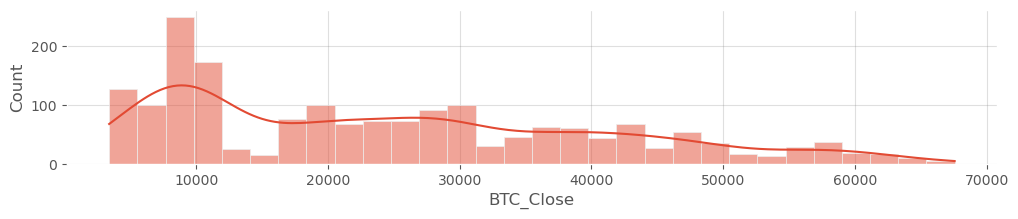

count     1825.000000
mean     24605.077542
std      16061.670187
min       3399.471680
25%       9677.113281
50%      22206.792969
75%      36824.363281
max      67566.828125
Name: BTC_Close, dtype: float64
Skewness: 0.5916667110225395
Kurtosis: -0.6657934229209417


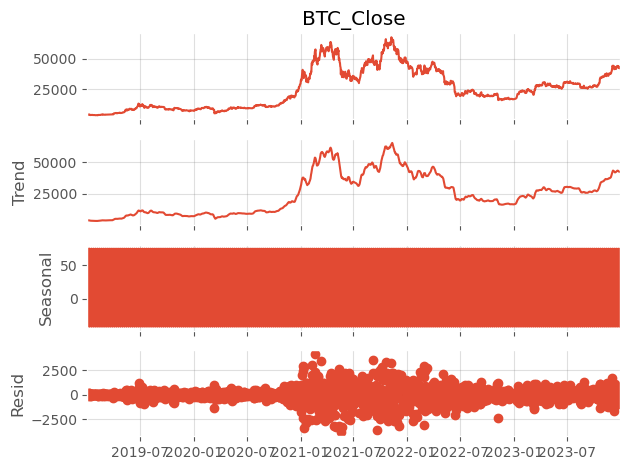

ADF Statistic: -1.5760666189952015
ADF p-value: 0.4956038818426764
ADF Critical Values:
    1%: -3.4339881389288407
    5%: -2.863147035877915
    10%: -2.567625533641975
The series is not stationary according to the ADF test.
KPSS Statistic: 2.533002523020806
KPSS p-value: 0.01
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely non-stationary according to the KPSS test.
-----------------------------------ETH_Close's descriptive statistics-----------------------------------


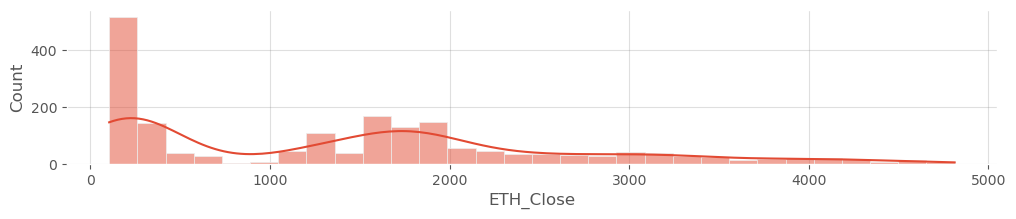

count    1825.000000
mean     1410.140421
std      1165.855430
min       104.535301
25%       233.086700
50%      1469.741699
75%      1981.336548
max      4812.087402
Name: ETH_Close, dtype: float64
Skewness: 0.678709004106351
Kurtosis: -0.3094830505457633


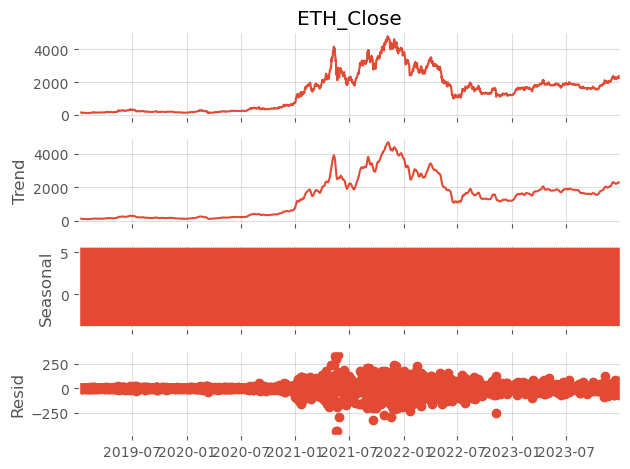

ADF Statistic: -1.491633154492771
ADF p-value: 0.5376461627720104
ADF Critical Values:
    1%: -3.4339740253219566
    5%: -2.863140805408186
    10%: -2.5676222161097058
The series is not stationary according to the ADF test.
KPSS Statistic: 3.165596228997213
KPSS p-value: 0.01
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely non-stationary according to the KPSS test.
-----------------------------------SP500's descriptive statistics-----------------------------------


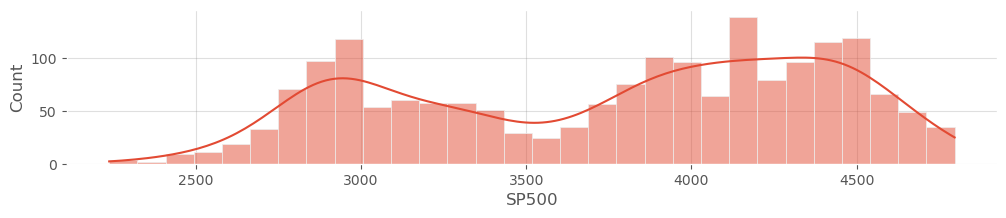

count    1825.000000
mean     3757.688077
std       633.365575
min      2237.399902
25%      3131.290039
50%      3902.620117
75%      4308.500000
max      4796.560059
Name: SP500, dtype: float64
Skewness: -0.2924667513261902
Kurtosis: -1.2254808250057807


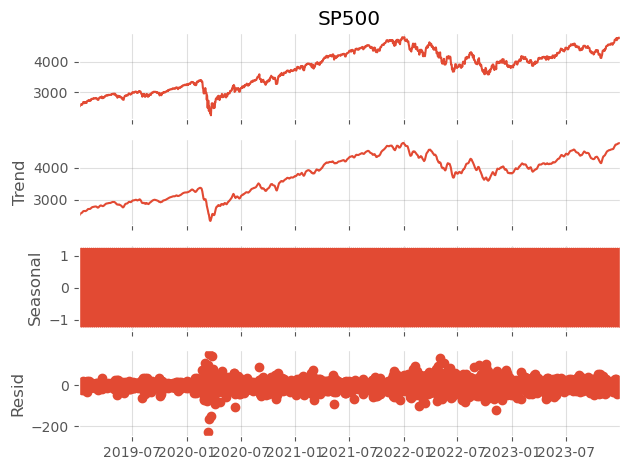

ADF Statistic: -1.3832269338691523
ADF p-value: 0.5902904003252736
ADF Critical Values:
    1%: -3.433968010099092
    5%: -2.8631381499714745
    10%: -2.567620802173316
The series is not stationary according to the ADF test.
KPSS Statistic: 4.950365811477612
KPSS p-value: 0.01
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely non-stationary according to the KPSS test.
-----------------------------------NASDAQ's descriptive statistics-----------------------------------


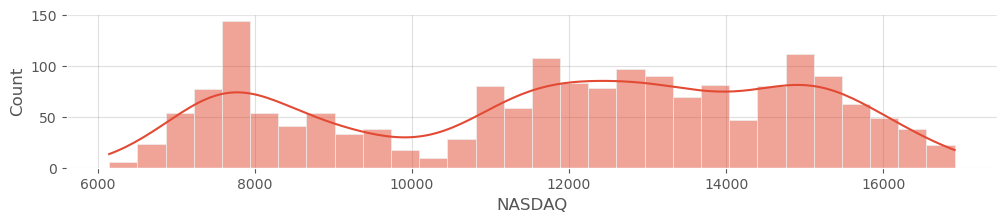

count     1825.000000
mean     11866.965154
std       2882.254702
min       6147.129883
25%       9079.629883
50%      12258.209961
75%      14365.959961
max      16906.800781
Name: NASDAQ, dtype: float64
Skewness: -0.26093213827017475
Kurtosis: -1.1581095498791043


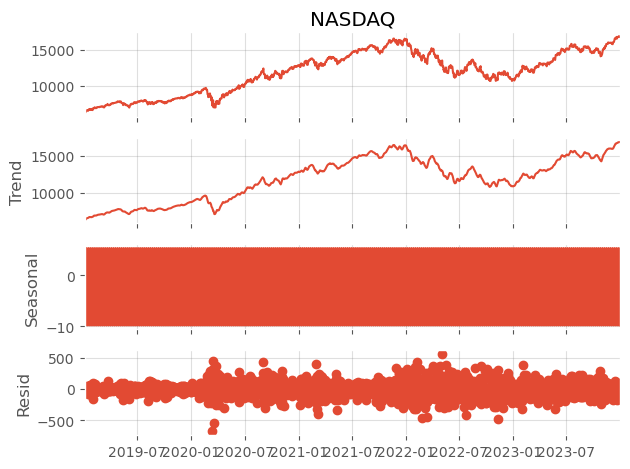

ADF Statistic: -1.1354171380918614
ADF p-value: 0.7007433542761805
ADF Critical Values:
    1%: -3.433968010099092
    5%: -2.8631381499714745
    10%: -2.567620802173316
The series is not stationary according to the ADF test.
KPSS Statistic: 4.456590683874746
KPSS p-value: 0.01
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely non-stationary according to the KPSS test.
-----------------------------------USD_Index's descriptive statistics-----------------------------------


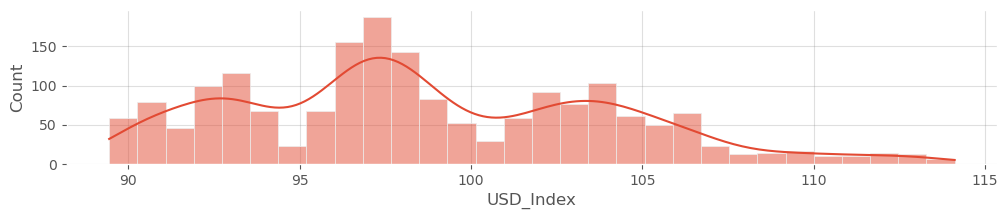

count    1825.000000
mean       98.625699
std         5.343082
min        89.440002
25%        94.250000
50%        97.730003
75%       102.820000
max       114.110001
Name: USD_Index, dtype: float64
Skewness: 0.42036230198161323
Kurtosis: -0.4019329314669835


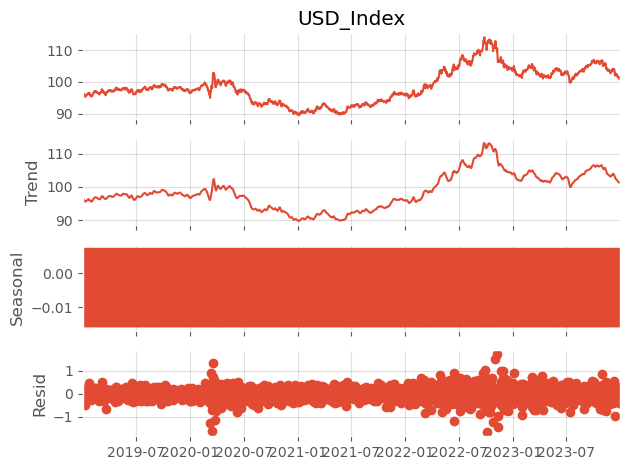

ADF Statistic: -1.3346142622961985
ADF p-value: 0.6131912813887304
ADF Critical Values:
    1%: -3.433966009459769
    5%: -2.8631372667825503
    10%: -2.567620331903232
The series is not stationary according to the ADF test.
KPSS Statistic: 2.865571499938636
KPSS p-value: 0.01
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely non-stationary according to the KPSS test.
-----------------------------------Gold's descriptive statistics-----------------------------------


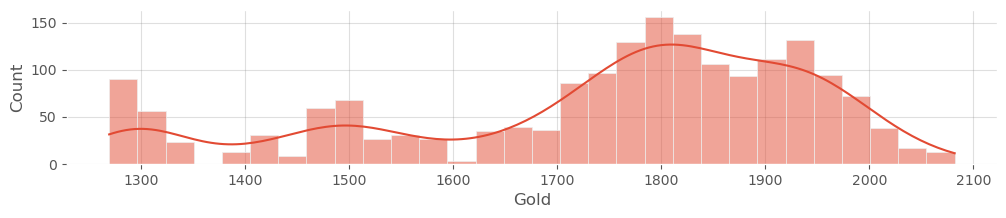

count    1825.000000
mean     1741.366957
std       206.292477
min      1269.300049
25%      1641.699951
50%      1795.900024
75%      1898.599976
max      2081.899902
Name: Gold, dtype: float64
Skewness: -0.8533910562669826
Kurtosis: -0.24785210967665838


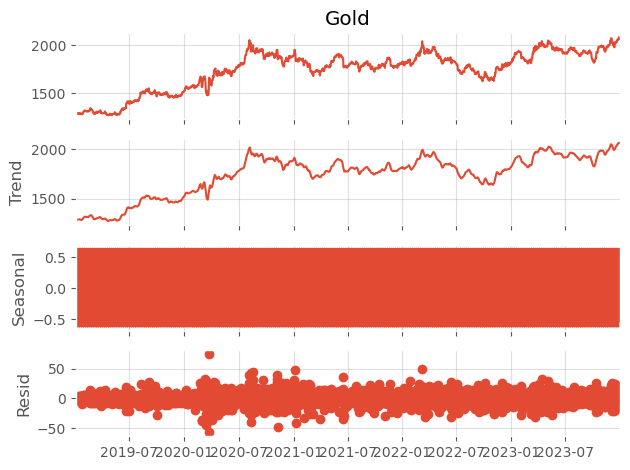

ADF Statistic: -1.7684918492802333
ADF p-value: 0.3962129637568643
ADF Critical Values:
    1%: -3.433962014811523
    5%: -2.86313550332995
    10%: -2.5676193929209554
The series is not stationary according to the ADF test.
KPSS Statistic: 4.213850558730211
KPSS p-value: 0.01
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely non-stationary according to the KPSS test.
-----------------------------------BTC_users's descriptive statistics-----------------------------------


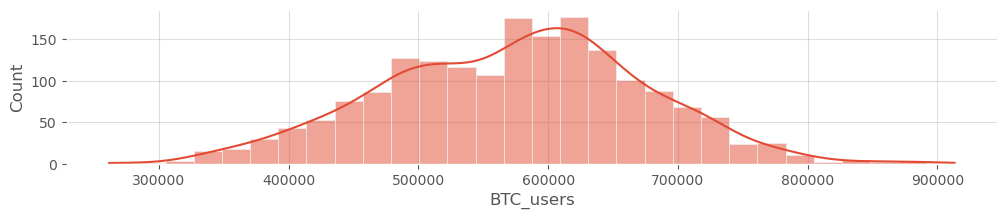

count      1825.000000
mean     573585.360000
std       99385.359956
min      261688.000000
25%      502703.000000
50%      579811.000000
75%      639336.000000
max      913280.000000
Name: BTC_users, dtype: float64
Skewness: -0.06240122710985823
Kurtosis: -0.2040892682646156


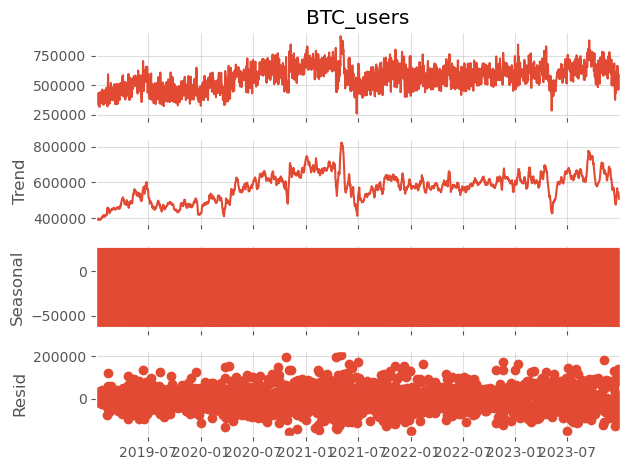

ADF Statistic: -3.7993819004606983
ADF p-value: 0.002913645294536177
ADF Critical Values:
    1%: -3.4339840952648695
    5%: -2.8631452508003057
    10%: -2.567624583142913
The series is stationary according to the ADF test.
KPSS Statistic: 2.8344480653657422
KPSS p-value: 0.01
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely non-stationary according to the KPSS test.
-----------------------------------BTC_tx_count's descriptive statistics-----------------------------------


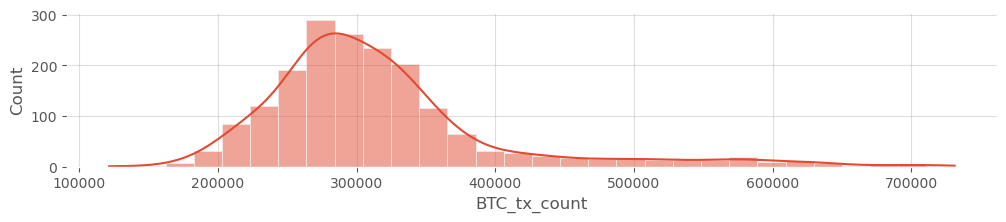

count      1825.000000
mean     315847.263562
std       86161.893005
min      121538.000000
25%      265239.000000
50%      297595.000000
75%      338484.000000
max      731351.000000
Name: BTC_tx_count, dtype: float64
Skewness: 1.8478673469741107
Kurtosis: 4.322619334513877


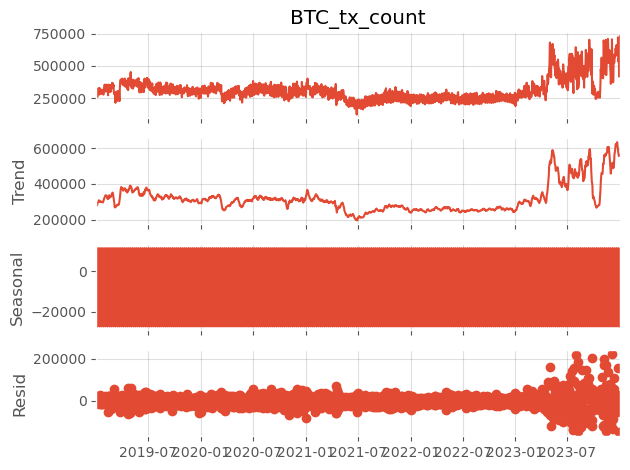

ADF Statistic: -2.282064900867883
ADF p-value: 0.17781765608749983
ADF Critical Values:
    1%: -3.4339840952648695
    5%: -2.8631452508003057
    10%: -2.567624583142913
The series is not stationary according to the ADF test.
KPSS Statistic: 1.2835660324743523
KPSS p-value: 0.01
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely non-stationary according to the KPSS test.


In [4]:
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

def descriptive_stats(dataframe, specific_column): 
    
    print(f"-----------------------------------{specific_column}'s descriptive statistics-----------------------------------")

    plt.figure(figsize=(12, 2))
    sns.histplot(dataframe[specific_column], kde=True, bins=30)
    plt.show()
    
    descriptive_stats = dataframe[specific_column].describe()
    skewness = dataframe[specific_column].skew()
    kurtosis = dataframe[specific_column].kurtosis()
    
    print(descriptive_stats)
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")
    
    specific_decomposition =\
        (seasonal_decompose(dataframe[specific_column],
        model = "additive")) # Using additive model since returns have negative values
    specific_decomposition.plot()
    plt.show()
    
    # ADF Test
    adf_result = adfuller(dataframe[specific_column])
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"ADF p-value: {adf_result[1]}")
    print("ADF Critical Values:")
    for key, value in adf_result[4].items():
        print(f'    {key}: {value}')
    if adf_result[1] < 0.05:
        print("The series is stationary according to the ADF test.")
    else:
        print("The series is not stationary according to the ADF test.")
        
    # KPSS Test
    kpss_result = kpss(dataframe[specific_column], nlags="auto")
    print(f"KPSS Statistic: {kpss_result[0]}")
    print(f"KPSS p-value: {kpss_result[1]}")
    print("KPSS Critical Values:")
    for key, value in kpss_result[3].items():
        print(f'    {key}: {value}')
    if kpss_result[1] < 0.05:
        print("The series is likely non-stationary according to the KPSS test.")
    else:
        print("The series is likely stationary according to the KPSS test.")
    
    return dataframe 

for i in data.columns:
    descriptive_stats(data, i)

In [5]:
return_period = 7

# To ensure stationarity by calculate 7-day returns for cryptocurrencies and 5-day returns for the remaining
data['BTC_Return'] = np.log(data['BTC_Close']).diff(return_period)
data['ETH_Return'] = np.log(data['ETH_Close']).diff(return_period)

data['BTC_users'] = np.log(data['BTC_users']).diff(return_period)
data['BTC_tx_count'] = np.log(data['BTC_tx_count']).diff(return_period)


# 5 days for equities, gold, fx indexes
data[["SP500", "NASDAQ", "USD_Index", "Gold"]] =\
                                                (np.log(data[["SP500", "NASDAQ", "USD_Index", "Gold"]])
                                                 .diff(return_period))

data.dropna(inplace = True)
data.drop(['BTC_Close', 'ETH_Close'], axis=1, inplace=True)
data.head()

SP500    NASDAQ  USD_Index      Gold  BTC_users  BTC_tx_count  \
2019-01-09  0.029415  0.037009  -0.016664  0.006458   0.015757      0.160683   
2019-01-10  0.058992  0.074252  -0.008027 -0.005511   0.056485      0.117615   
2019-01-11  0.025086  0.027448  -0.005421  0.003424   0.054259      0.090209   
2019-01-12  0.025086  0.027448  -0.005421  0.003424  -0.002547      0.059685   
2019-01-13  0.025086  0.027448  -0.005421  0.003424  -0.064243      0.069026   

            BTC_Return  ETH_Return  
2019-01-09    0.023034   -0.027758  
2019-01-10   -0.042003   -0.147949  
2019-01-11   -0.045163   -0.192229  
2019-01-12   -0.049006   -0.211520  
2019-01-13   -0.137492   -0.299687

-----------------------------------SP500's descriptive statistics-----------------------------------


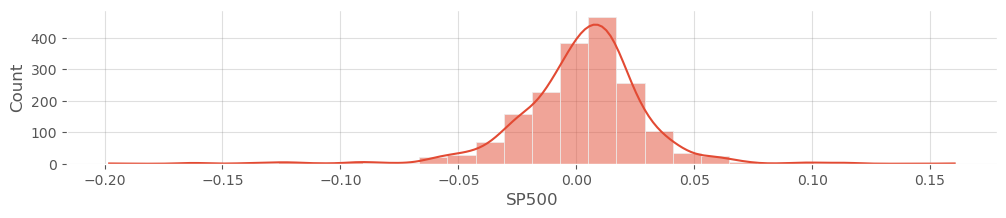

count    1818.000000
mean        0.002451
std         0.027005
min        -0.198044
25%        -0.009973
50%         0.005058
75%         0.016544
max         0.160395
Name: SP500, dtype: float64
Skewness: -1.0480971725040102
Kurtosis: 7.603557689662232


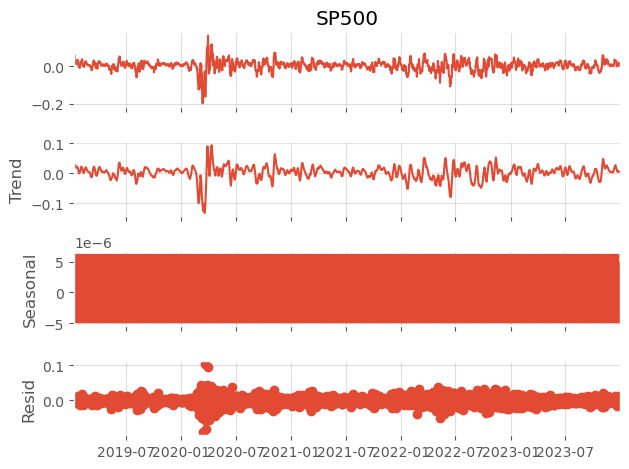

ADF Statistic: -8.19154649388376
ADF p-value: 7.643969672663307e-13
ADF Critical Values:
    1%: -3.4340044039750235
    5%: -2.863154216066867
    10%: -2.5676293568762953
The series is stationary according to the ADF test.
KPSS Statistic: 0.08674131281006318
KPSS p-value: 0.1
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely stationary according to the KPSS test.
-----------------------------------NASDAQ's descriptive statistics-----------------------------------


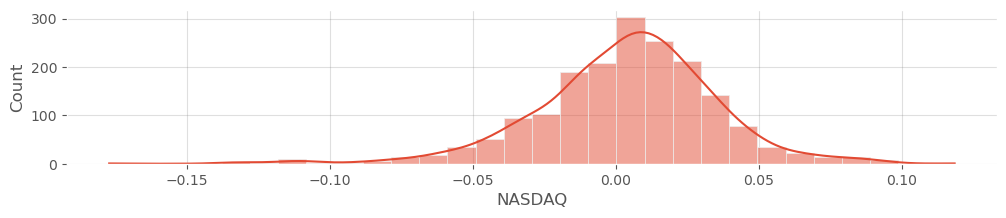

count    1818.000000
mean        0.003726
std         0.031402
min        -0.177178
25%        -0.012777
50%         0.006141
75%         0.021924
max         0.118572
Name: NASDAQ, dtype: float64
Skewness: -0.6167442626014084
Kurtosis: 2.305392539202759


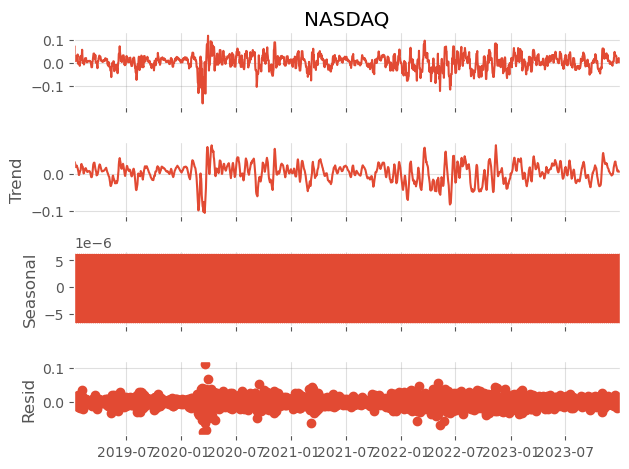

ADF Statistic: -7.982672507485265
ADF p-value: 2.5981176414867073e-12
ADF Critical Values:
    1%: -3.4340044039750235
    5%: -2.863154216066867
    10%: -2.5676293568762953
The series is stationary according to the ADF test.
KPSS Statistic: 0.1673515129725136
KPSS p-value: 0.1
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely stationary according to the KPSS test.
-----------------------------------USD_Index's descriptive statistics-----------------------------------


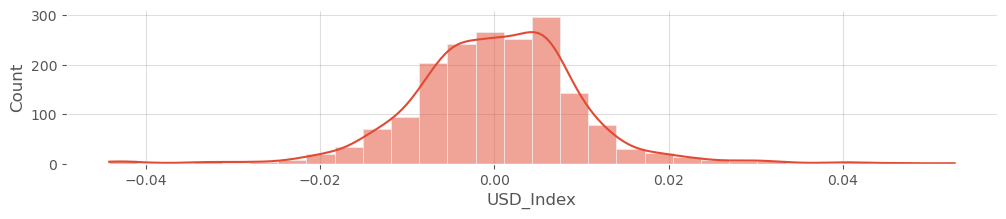

count    1818.000000
mean        0.000201
std         0.009623
min        -0.044244
25%        -0.005372
50%         0.000310
75%         0.005904
max         0.052852
Name: USD_Index, dtype: float64
Skewness: -0.02153710184477476
Kurtosis: 3.395494005671586


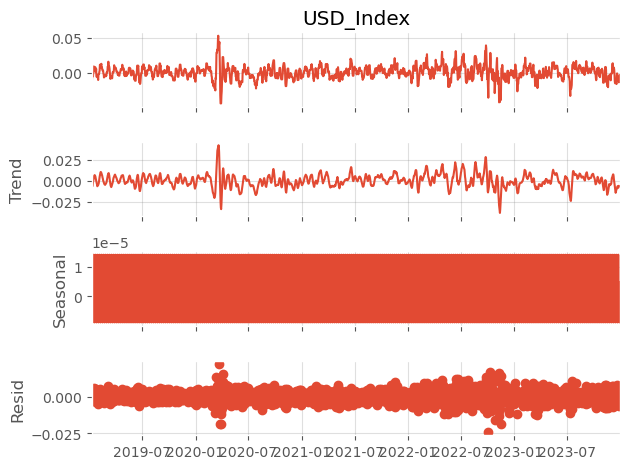

ADF Statistic: -7.4027136263990805
ADF p-value: 7.481931928778417e-11
ADF Critical Values:
    1%: -3.433996253313391
    5%: -2.863150617970021
    10%: -2.5676274409973163
The series is stationary according to the ADF test.
KPSS Statistic: 0.1217985437810831
KPSS p-value: 0.1
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely stationary according to the KPSS test.
-----------------------------------Gold's descriptive statistics-----------------------------------


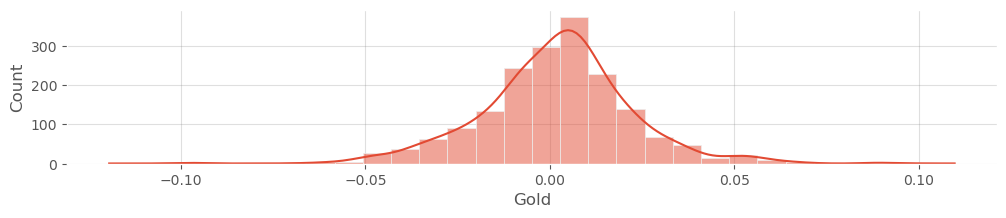

count    1818.000000
mean        0.001829
std         0.021284
min        -0.119494
25%        -0.009130
50%         0.003090
75%         0.012865
max         0.109740
Name: Gold, dtype: float64
Skewness: -0.12082192765650737
Kurtosis: 2.975810214569006


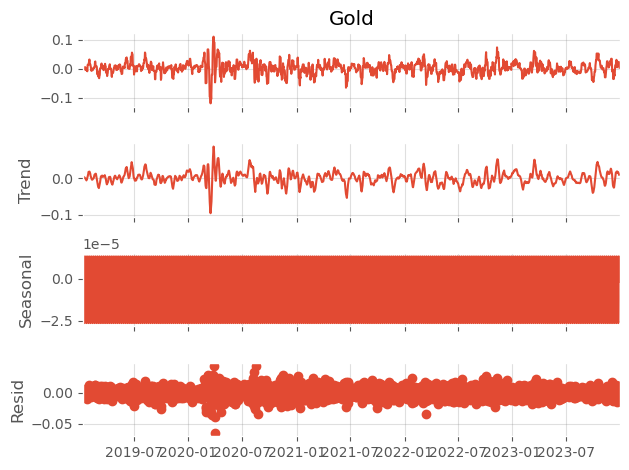

ADF Statistic: -8.810331071981642
ADF p-value: 1.9993674951250273e-14
ADF Critical Values:
    1%: -3.433996253313391
    5%: -2.863150617970021
    10%: -2.5676274409973163
The series is stationary according to the ADF test.
KPSS Statistic: 0.12551155266055972
KPSS p-value: 0.1
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely stationary according to the KPSS test.
-----------------------------------BTC_users's descriptive statistics-----------------------------------


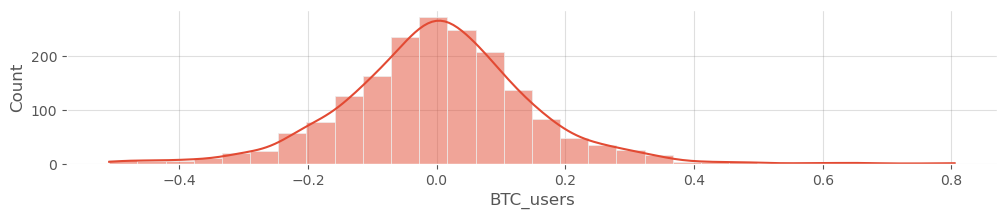

count    1818.000000
mean        0.001015
std         0.141137
min        -0.509006
25%        -0.080364
50%         0.002592
75%         0.082269
max         0.805062
Name: BTC_users, dtype: float64
Skewness: 0.0952598346165456
Kurtosis: 1.8005220188093434


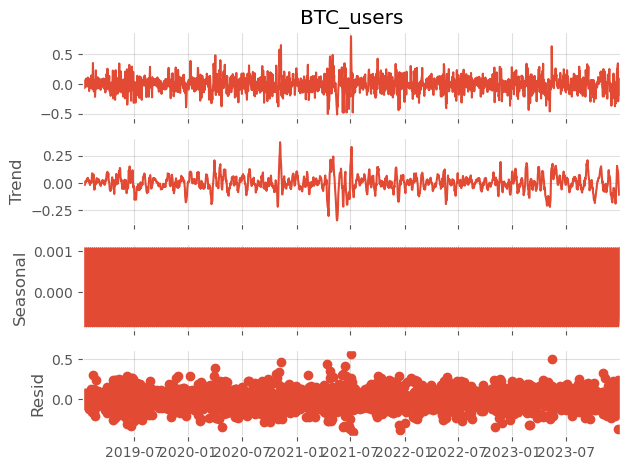

ADF Statistic: -12.0603101093968
ADF p-value: 2.4782048312166935e-22
ADF Critical Values:
    1%: -3.433996253313391
    5%: -2.863150617970021
    10%: -2.5676274409973163
The series is stationary according to the ADF test.
KPSS Statistic: 0.06635521693884283
KPSS p-value: 0.1
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely stationary according to the KPSS test.
-----------------------------------BTC_tx_count's descriptive statistics-----------------------------------


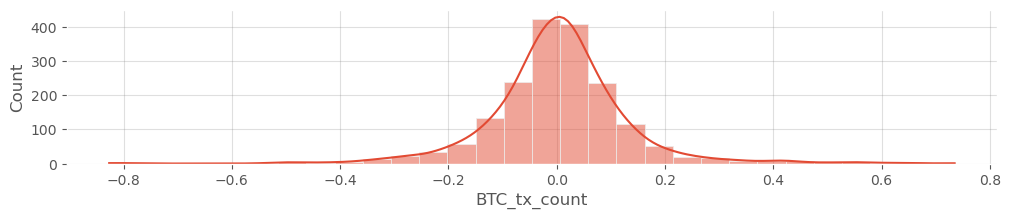

count    1818.000000
mean        0.002589
std         0.127930
min        -0.826618
25%        -0.056238
50%         0.003068
75%         0.060569
max         0.735014
Name: BTC_tx_count, dtype: float64
Skewness: 0.1970207357786923
Kurtosis: 5.584799596200931


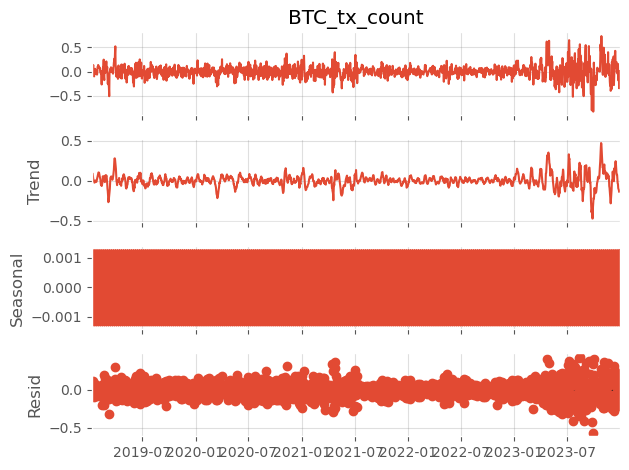

ADF Statistic: -10.599088674913512
ADF p-value: 6.238282142541109e-19
ADF Critical Values:
    1%: -3.433996253313391
    5%: -2.863150617970021
    10%: -2.5676274409973163
The series is stationary according to the ADF test.
KPSS Statistic: 0.08299666462792321
KPSS p-value: 0.1
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely stationary according to the KPSS test.
-----------------------------------BTC_Return's descriptive statistics-----------------------------------


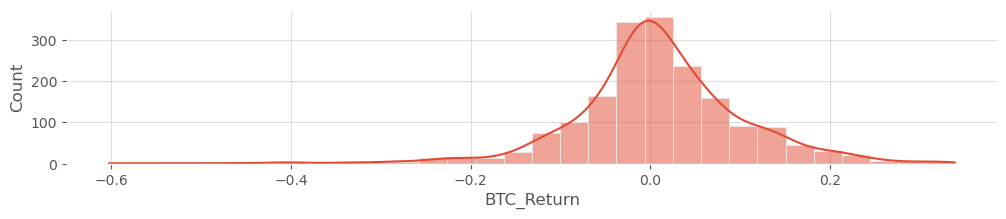

count    1818.000000
mean        0.009168
std         0.094628
min        -0.602360
25%        -0.033913
50%         0.005423
75%         0.056460
max         0.339034
Name: BTC_Return, dtype: float64
Skewness: -0.5313869805319206
Kurtosis: 3.8550181824364795


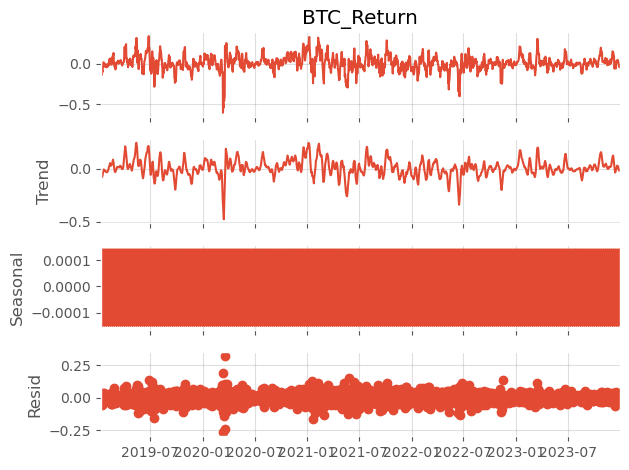

ADF Statistic: -7.296626280028681
ADF p-value: 1.372574735896892e-10
ADF Critical Values:
    1%: -3.4340044039750235
    5%: -2.863154216066867
    10%: -2.5676293568762953
The series is stationary according to the ADF test.
KPSS Statistic: 0.20679046584516458
KPSS p-value: 0.1
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely stationary according to the KPSS test.
-----------------------------------ETH_Return's descriptive statistics-----------------------------------


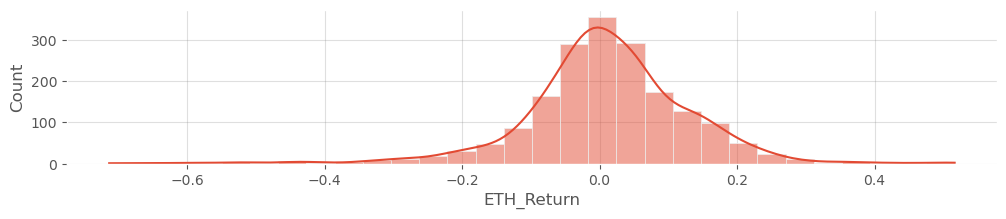

count    1818.000000
mean        0.010427
std         0.119745
min        -0.713299
25%        -0.047563
50%         0.008251
75%         0.072081
max         0.516493
Name: ETH_Return, dtype: float64
Skewness: -0.6469413748170955
Kurtosis: 4.151064210870507


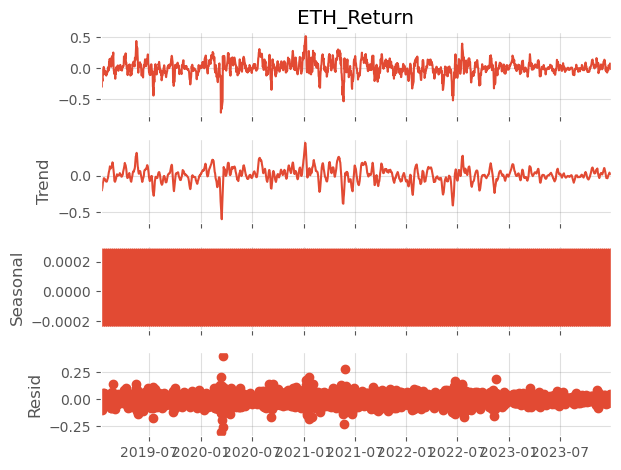

ADF Statistic: -7.336282432766547
ADF p-value: 1.0944028479625389e-10
ADF Critical Values:
    1%: -3.4340044039750235
    5%: -2.863154216066867
    10%: -2.5676293568762953
The series is stationary according to the ADF test.
KPSS Statistic: 0.1750058167904934
KPSS p-value: 0.1
KPSS Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
The series is likely stationary according to the KPSS test.


In [6]:
for i in data.columns:
    descriptive_stats(data, i)

# <u>1. ARIMA - Manual Parameter Tuning</u>

## Estimating the P and Q for ARIMA models 

In [7]:
window_size = 100 
forecast_horizon = 1

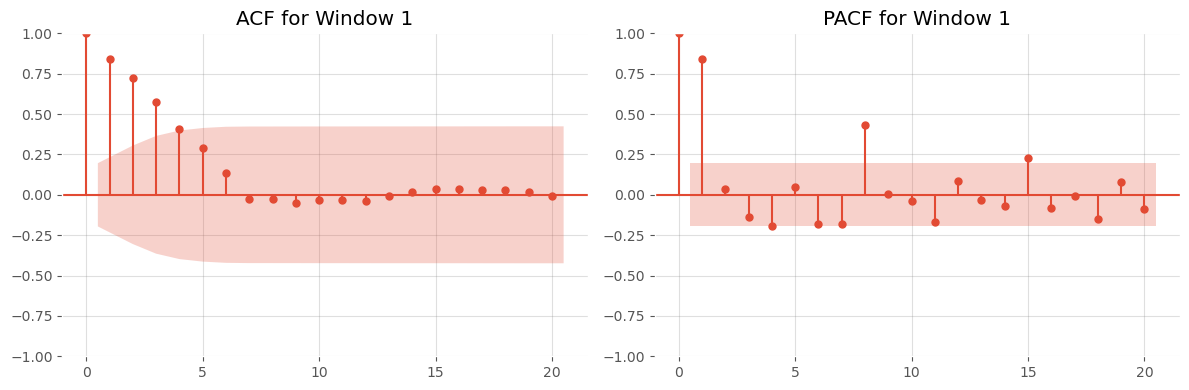

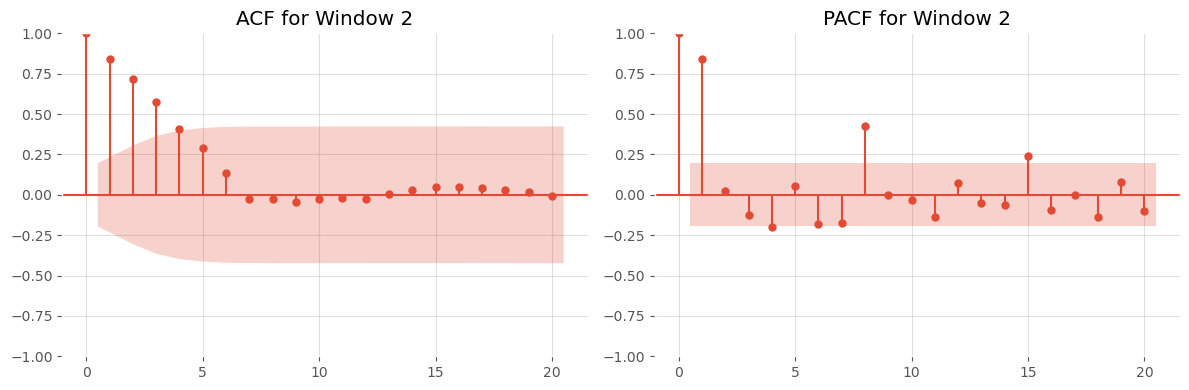

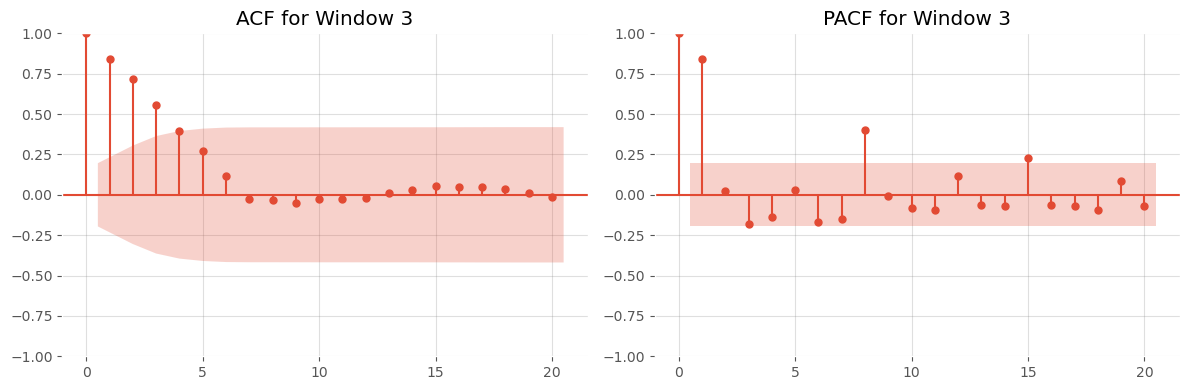

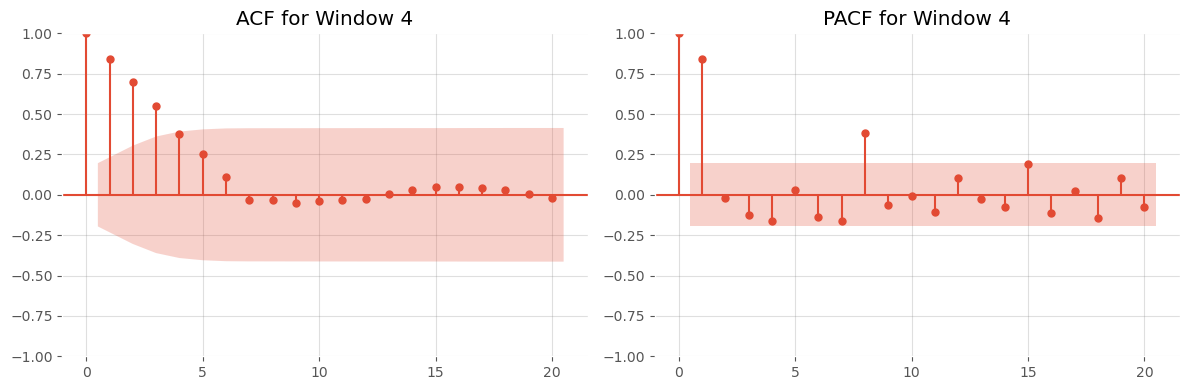

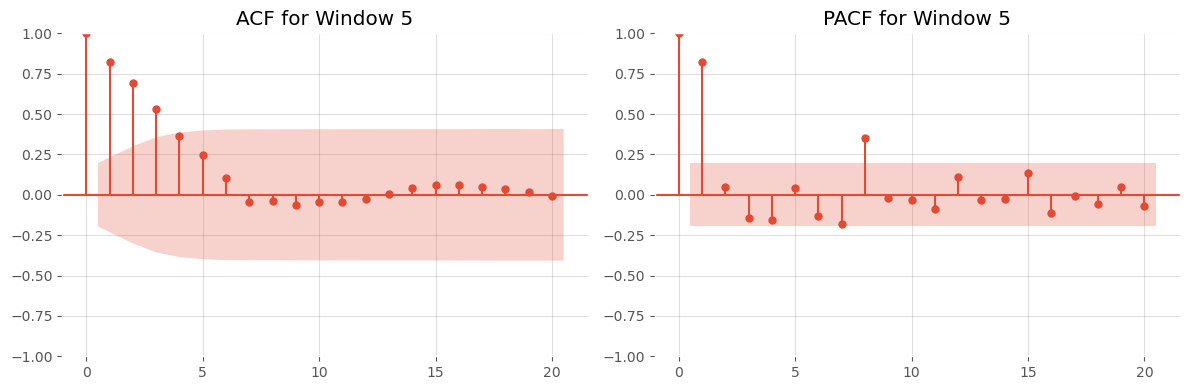

In [8]:
# To determine the p and q for the ARIMA model 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

window_size = 100 
forecast_horizon = 1

for i in range(5):  # Modify the loop to only run for the first five windows
    train_window = data['BTC_Return'].iloc[i: i + window_size]
    
    # Plot ACF
    plt.figure(figsize=(12, 4))
    plt.subplot(121)  # 1 row, 2 columns, 1st subplot
    plot_acf(train_window, ax=plt.gca(), lags=20, title=f'ACF for Window {i+1}')
    
    # Plot PACF
    plt.subplot(122)  # 1 row, 2 columns, 2nd subplot
    plot_pacf(train_window, ax=plt.gca(), lags=20, title=f'PACF for Window {i+1}')
    
    plt.tight_layout()
    plt.show()


# <span style="color:yellow;">ACF and PACF Observations</span>

## ACF Analysis
The ACF plot displays a slower-than-exponential decay, which typically suggests the presence of an autoregressive component. However, the lack of pronounced spikes at specific lags indicates that a simple non-seasonal MA model may not fully capture the series' dynamics.

## PACF Analysis
The PACF plot shows a sharp cut-off after the first lag, indicating a likely AR(1) component. This cut-off is characteristic of an autoregressive process where only the first lag has a significant correlation with subsequent values, and this correlation quickly diminishes for higher lags.
Additionally, significant spikes at every seventh lag suggest a periodic or seasonal influence that might imply the need for a seasonal MA component, as the seasonal lag component exhibits a gradual decay behavior.

## Model Specification
Based on the observed behaviors in the ACF and PACF, the following model specifications are suggested:

### Non-Seasonal Component
- **AR(1)**: The significant autocorrelation at the first lag in the PACF suggests that an AR(1) component is appropriate for capturing the primary autocorrelation structure of the data.

### Seasonal Component
- **Seasonal MA(1) at Period 7**: The repeated significant spikes at every seventh lag with exponential decay in the PACF suggest a seasonal moving average component.

### Proposed SARIMA Model
Considering the above findings, a plausible SARIMA model for your data could be SARIMA(1,0,0)(0,0,1)[7], which includes:
- A non-seasonal AR(1) term.
- A seasonal MA(1) term with a periodicity of 7 days.
- No differencing (d=0, D=0), assuming the data is stationary.

### Proposed ARIMA Model
For hypothesis testing, a non-seasonal ARIMA(1,0,0) model will also be considered. The performance of this model will be compared with the seasonal SARIMA model based on their AICc values.


## <span style="color:red;">ARIMA(1,0,0)</span>

In [10]:
from statsmodels.tsa.arima.model import ARIMA

btc_forecasts_arima = []
btc_true_arima = []
aics = []
btc_true_close_prices = []
btc_forecasted_close_prices = []
# Initial close price (starting point for cumulative calculations)
initial_btc_price = btc_data['BTC_Close'].iloc[0]

for i in range(len(data) - window_size - forecast_horizon + 1):
    train_window = data['BTC_Return'].iloc[i: i + window_size]
    test_point = data['BTC_Return'].iloc[i + window_size: i + window_size + forecast_horizon]

    # Fit the SARIMA model manually 
    model_arima = ARIMA(train_window, order=(1, 0, 0))
    arima_fit = model_arima.fit()

    # Calculate AICc for the model fit
    aic = arima_fit.aic
    aics.append(aic)  # Store the AICc

    # To obtain the sarima model's forecast
    arima_forecast = arima_fit.get_forecast(steps = forecast_horizon)
    final_forecast = arima_forecast.predicted_mean.values[-1]
    
    # Append the forecast and true value to the lists
    btc_forecasts_arima.append(final_forecast)
    btc_true_arima.append(test_point.values[0])

    # Calculate the cumulative close price at the end of the rolling window
    cumulative_return_train = np.sum(train_window)
    last_known_close_price = initial_btc_price * np.exp(cumulative_return_train)
    
    # Calculate true and forecasted close prices based on the derived last known close price
    true_close_price = last_known_close_price * np.exp(test_point.values[0])
    forecasted_close_price = last_known_close_price * np.exp(final_forecast)
    
    # Append to lists for MAPE calculation
    btc_true_close_prices.append(true_close_price)
    btc_forecasted_close_prices.append(forecasted_close_price)

# Calculate the mean AICc for the current model
mean_aic = sum(aics) / len(aics)

# print(f"AICc for ARIMA: {aics}")
print(f"Mean AICc for ARIMA: {mean_aic}")


AICc for ARIMA: [-370.6426010608409, -372.9513871058491, -372.92775535074287, -372.81779661283736, -375.0853029878441, -378.8949156732267, -378.69065300891293, -376.88413437172517, -385.56140779057733, -385.4148033836331, -386.0581330809944, -385.38765146116623, -386.427306792016, -387.05722245958145, -383.8933825477428, -382.69185745983174, -382.39034243252246, -382.44396380397393, -383.446810320406, -383.6260465447849, -383.1121631779048, -383.2309686599244, -383.22878269661845, -371.99217848853255, -372.248598454178, -358.43013364848906, -358.62755110605553, -358.4259427071936, -357.13078067829946, -352.87983093539003, -346.8834906713335, -335.10402494622593, -327.51080313774304, -327.11538489492517, -324.6861100251686, -323.7062958193398, -321.1164732357598, -322.68823723248926, -322.1181438417974, -321.41560357858896, -323.86611628829894, -323.31677234841925, -321.9649526703881, -321.92020774183595, -321.9050619623371, -320.77582146132835, -321.35252053285745, -319.6471633976006, 

<Figure size 1000x600 with 0 Axes>

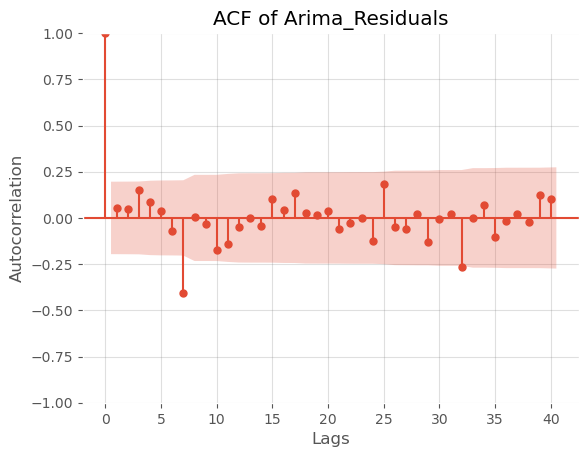

Ljung-Box Test Results:
      lb_stat  lb_pvalue
1    0.271919   0.602047
7   22.606363   0.001995
14  28.944469   0.010633


In [11]:
arima_residuals = arima_fit.resid

# Plot ACF of arima_residuals
plt.figure(figsize=(10, 6))
plot_acf(arima_residuals, alpha=0.05, lags=40)
plt.title('ACF of Arima_Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test on arima_residuals at various lags
lags_to_test = [1, 7, 14]  # Including multiple lags for a comprehensive check
lb_test = acorr_ljungbox(arima_residuals, lags=lags_to_test, return_df=True)

# Print the Ljung-Box test results
print("Ljung-Box Test Results:")
print(lb_test)

                               SARIMAX Results                                
Dep. Variable:             BTC_Return   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 210.641
Date:                Tue, 05 Nov 2024   AIC                           -415.282
Time:                        19:54:12   BIC                           -407.467
Sample:                    09-22-2023   HQIC                          -412.119
                         - 12-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0275      0.020      1.362      0.173      -0.012       0.067
ar.L1          0.8511      0.051     16.681      0.000       0.751       0.951
sigma2         0.0009      0.000      8.113      0.0

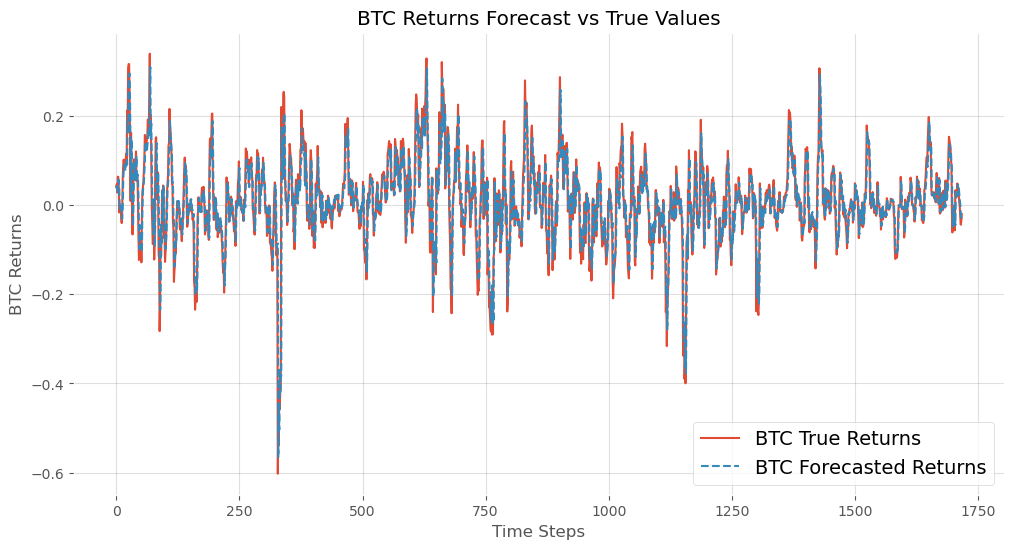

In [12]:
# To obtain arima model's accuracy results

print(arima_fit.summary())

mse_btc = mean_squared_error(btc_true_arima, btc_forecasts_arima)
rmse_btc = np.sqrt(mse_btc)

# Calculate MAPE based on close prices
mape_btc = np.mean(np.abs((np.array(btc_true_close_prices) - np.array(btc_forecasted_close_prices)) / np.array(btc_true_close_prices))) * 100

r2_btc = r2_score(btc_true_arima, btc_forecasts_arima)

print(f'RMSE for BTC: {rmse_btc}')
print(f'MAPE for BTC: {mape_btc:.2f}%')
print(f'R² for BTC: {r2_btc}')

plt.figure(figsize=(12, 6))
plt.plot(range(len(btc_true_arima)), btc_true_arima, 
         label='BTC True Returns')
plt.plot(range(len(btc_forecasts_arima)), btc_forecasts_arima, 
         label='BTC Forecasted Returns', linestyle='--')
plt.legend()
plt.title('BTC Returns Forecast vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('BTC Returns')
plt.show()

## <span style="color:red;">SARIMA(1,0,0)(0,0,1)[7]</span>

In [13]:
btc_data

BTC_Close
Date                    
2019-01-01   3843.520020
2019-01-02   3943.409424
2019-01-03   3836.741211
2019-01-04   3857.717529
2019-01-05   3845.194580
...                  ...
2023-12-26  42520.402344
2023-12-27  43442.855469
2023-12-28  42627.855469
2023-12-29  42099.402344
2023-12-30  42156.902344

[1825 rows x 1 columns]

In [14]:
btc_forecasts_sarima = []
btc_true_sarima = []
btc_true_close_prices = []
btc_forecasted_close_prices = []
aics = []
# Initial close price (starting point for cumulative calculations)
initial_btc_price = btc_data['BTC_Close'].iloc[0]

from statsmodels.tsa.statespace.sarimax import SARIMAX

for i in range(len(data) - window_size - forecast_horizon + 1):
    
    train_window = data['BTC_Return'].iloc[i: i + window_size]
    test_point = data['BTC_Return'].iloc[i + window_size: i + window_size + forecast_horizon]

    model_sarima = SARIMAX(train_window, order=(1, 0, 0), seasonal_order=(0, 0, 1, 7))
    sarima_fit = model_sarima.fit(disp=False) #, maxiter=100, tol=1e-3)

    # Calculate AICc for the model fit
    aic = sarima_fit.aic
    aics.append(aic)  # Store the AICc

    sarima_forecast = sarima_fit.get_forecast(steps=forecast_horizon)
    final_forecast = sarima_forecast.predicted_mean.values[-1]

    btc_forecasts_sarima.append(final_forecast)
    btc_true_sarima.append(test_point.values[0])

    # Calculate the cumulative close price at the end of the rolling window
    cumulative_return_train = np.sum(train_window)
    last_known_close_price = initial_btc_price * np.exp(cumulative_return_train)
    
    # Calculate true and forecasted close prices based on the derived last known close price
    true_close_price = last_known_close_price * np.exp(test_point.values[0])
    forecasted_close_price = last_known_close_price * np.exp(final_forecast)
    
    # Append to lists for MAPE calculation
    btc_true_close_prices.append(true_close_price)
    btc_forecasted_close_prices.append(forecasted_close_price)

# Calculate the mean AICc for the current model
mean_aic = sum(aics) / len(aics)

# print(f"AICc for ARIMA: {aics}")
print(f"Mean AICc for ARIMA: {mean_aic}")

AICc for ARIMA: [-420.4571317971015, -420.6449179370062, -420.6383757920743, -420.7077512204489, -427.27302301101906, -426.94249920696063, -426.45464187512715, -424.8466654489259, -434.60136356889063, -435.82648431530214, -434.39785638783803, -436.41992520052077, -438.1969619192768, -441.2090992798265, -439.58382591146636, -436.46798903804313, -436.7345693499521, -437.1073532606101, -438.1479679992762, -439.58410631019524, -437.09838953795423, -434.0436517649257, -433.4867307093636, -416.67365565827515, -415.9533879276413, -399.7202255457662, -401.61919653589945, -401.95201319673794, -400.722332875501, -392.68294821348275, -392.06528754534673, -376.2886996475718, -375.3197311593475, -375.06437583559074, -373.77862152433255, -369.7130021373565, -373.03086478293926, -374.73580479513544, -372.8773391815123, -372.81815197219004, -372.40735028985074, -372.56089873484206, -371.7293975150846, -371.202478284028, -371.04733461269905, -370.97048030419523, -366.7785664600052, -365.19443417034535,

In [15]:
sarima_fit

<Figure size 1000x600 with 0 Axes>

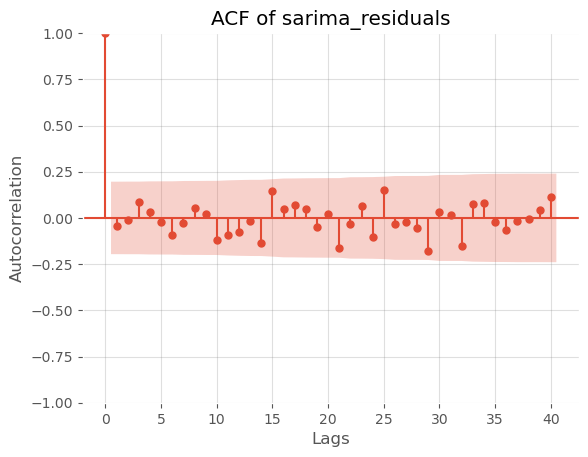

Ljung-Box Test Results:
     lb_stat  lb_pvalue
1   0.205947   0.649963
7   2.185754   0.948848
14  8.065994   0.885860


In [16]:
sarima_residuals = sarima_fit.resid

# Plot ACF of sarima_residuals
plt.figure(figsize=(10, 6))
plot_acf(sarima_residuals, alpha=0.05, lags=40)
plt.title('ACF of sarima_residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test on sarima_residuals at various lags
lags_to_test = [1, 7, 14]  # Including multiple lags for a comprehensive check
lb_test = acorr_ljungbox(sarima_residuals, lags=lags_to_test, return_df=True)

# Print the Ljung-Box test results
print("Ljung-Box Test Results:")
print(lb_test)

### <span style="color:yellow;">White Noise Check of SARIMA Model Residuals</span>

#### ACF Analysis of Residuals
- **Observation**: The ACF of the residuals largely falls within the confidence bounds across the specified lags.
- **Implication**: This pattern suggests that the residuals are consistent with white noise, indicating that the SARIMA model has effectively captured the underlying patterns in the data without leaving any systematic autocorrelation unaddressed.

#### Ljung-Box Test Results
- **Observation**: The p-values from the Ljung-Box test are predominantly above the 5% threshold.
- **Interpretation**: These results suggest a failure to reject the null hypothesis of the Ljung-Box test, which posits no significant autocorrelation at the tested lags. Since the p-values are only slightly above 0.05, it implies that there is weak evidencåe against the null hypothesis.
- **Conclusion**: The residuals likely exhibit no significant autocorrelation, approaching the characteristics of white noise. This outcome supports the conclusion that the SARIMA model has adequately captured the temporal dependencies in the dataset, allowing for reliable forecasts and analyses based on this model.


                                      SARIMAX Results                                      
Dep. Variable:                          BTC_Return   No. Observations:                  100
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 7)   Log Likelihood                 232.318
Date:                             Tue, 05 Nov 2024   AIC                           -458.636
Time:                                     19:55:57   BIC                           -450.820
Sample:                                 09-22-2023   HQIC                          -455.472
                                      - 12-30-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000     32.312      0.031      0.975     -62.331      64.331
ma.S.L7       -0.9999    28

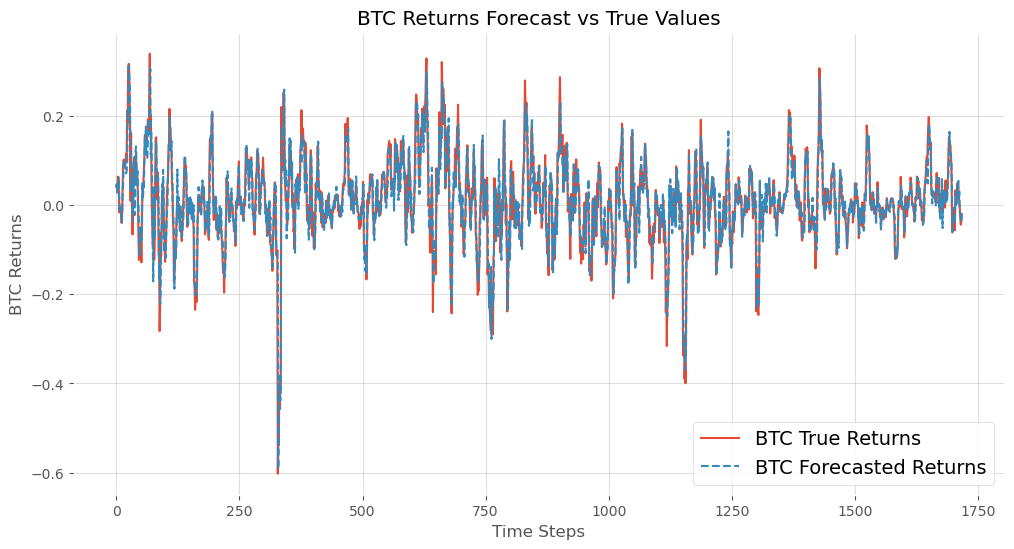

In [17]:
# To obtain sarima model's accuracy results

print(sarima_fit.summary())

mse_btc = mean_squared_error(btc_true_sarima, btc_forecasts_sarima)
rmse_btc = np.sqrt(mse_btc)

# Calculate MAPE based on close prices
mape_btc = np.mean(np.abs((np.array(btc_true_close_prices) - np.array(btc_forecasted_close_prices)) / np.array(btc_true_close_prices))) * 100

r2_btc = r2_score(btc_true_sarima, btc_forecasts_sarima)

print(f'RMSE for BTC: {rmse_btc}')
print(f'MAPE for BTC: {mape_btc:.2f}%')
print(f'R² for BTC: {r2_btc}')

plt.figure(figsize=(12, 6))
plt.plot(range(len(btc_true_sarima)), btc_true_sarima, 
         label='BTC True Returns')
plt.plot(range(len(btc_forecasts_sarima)), btc_forecasts_sarima, 
         label='BTC Forecasted Returns', linestyle='--')
plt.legend()
plt.title('BTC Returns Forecast vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('BTC Returns')
plt.show()

Certainly, let’s break down and evaluate the key summary statistics of your SARIMA model output to understand its performance and fit.

### 1. **Model Overview**
   - **Model**: `SARIMAX(1, 0, 0)x(0, 0, [1], 7)`
     - The model includes an autoregressive term (`AR(1)`) and a seasonal moving average component (`MA(1)` with a seasonal period of 7).
     - **Observations**: 100 data points from 09-22-2023 to 12-30-2023.

### 2. **Coefficient Estimates and Statistical Significance**
   -  **AR(1) (ar.L1)**: Coefficient = 1.0000, Std Err = 14.551, Z = 0.069, P>|z| = 0.945
  - This suggests the autoregressive term is very close to 1, indicating a potential unit root issue, or it could be part of a non-stationary process given the high p-value.
  
- **Seasonal MA(1) (ma.S.L7)**: Coefficient = -0.9999, Std Err = 126.336, Z = -0.008, P>|z| = 0.994
  - The coefficient is large but not statistically significant due to a very high standard error and a high p-value, suggesting that the seasonal MA term may not be contributing meaningfully to the model.

- **Sigma^2**: Coefficient = 0.0005, P>|z| = 0.993
  - The low variance in residuals suggests little unexplained noise, but the statistical insignificance (high p-value) suggests caution in interpreting this result as indicative of a good model fit.

### 3. Diagnostics of Residuals
- **Ljung-Box Test (Q)**: 
  - Q-stat = 0.24, P-value = 0.62
  - Indicates no significant autocorrelation at lag 1, suggesting that the model adequately captures the autocorrelation structure of the data.
  
- **Jarque-Bera (JB)**:
  - JB = 34.14, P-value = 0.00
  - Indicates that the residuals do not follow a normal distribution, suggesting potential issues with the underlying model assumptions or presence of outliers.

- **Heteroskedasticity (H) Test**:
  - H = 0.98, P-value (two-sided) = 0.95
  - Indicates no significant heteroskedasticity, suggesting stable variance of residuals across the sample.

### 4. Model Selection Criteria
- **AIC**: -458.633
- **BIC**: -450.818
- **HQIC**: -455.470
  - Lower values generally indicate a better fit. The low AIC and BIC values suggest the model is relatively efficient, though the high p-values for the coefficients might suggest overfitting or an incorrect model specification.

#### Plot Interpretation
- The ACF plot of the SARIMA residuals shows no significant autocorrelation across various lags, supporting the statistical tests that suggest an adequate model fit in terms of autocorrelation.

# <u>2. ARIMA - Auto Parameter Tuning</u>

In [18]:
btc_forecasts_arima = [] 
btc_true = []
aics = []

for i in range(len(data) - window_size - forecast_horizon + 1):
    train_window = data['BTC_Return'].iloc[i: i + window_size]
    test_point = data['BTC_Return'].iloc[i + window_size: i + window_size + forecast_horizon]

    # Using auto-arima to obtain optimal model 
    auto_arima_model = auto_arima(train_window, 
                                  start_p = 1, start_q = 1, 
                                  max_p = 5, max_q = 5, 
                                  seasonal = False, # based on seaonality decomposition, suggest no seaonality 
                                  trace = False, 
                                  error_action = 'ignore', 
                                  suppress_warnings = True, 
                                  stepwise = True)
    selected_order = auto_arima_model.order
   
    arima_model = ARIMA(train_window, order=selected_order)
    arima_fit = arima_model.fit()
    
    # Calculate AICc for the model fit
    aic = arima_fit.aic
    aics.append(aic)  # Store the AICc

    # Obtain ARIMA model's forecast
    arima_forecast = arima_fit.forecast(steps=forecast_horizon)
    mean_forecast = arima_forecast[-1] 
    
    # Append the forecast and true value
    btc_forecasts_arima.append(mean_forecast)
    btc_true.append(test_point.values[0])

# Calculate the mean AICc for the current model
mean_aic = sum(aics) / len(aics)

print(f"AICc for ARIMA: {aics}")
print(f"Mean AICc for ARIMA: {mean_aic}")

AICc for ARIMA: [-363.07968105397913, -365.9980728714059, -365.98738318871534, -365.7640714036163, -370.4807808073204, -372.7189664265308, -372.69672242612063, -376.88413437172517, -385.56140779057733, -385.4148033836331, -386.0581330809944, -385.38765146116623, -386.427306792016, -387.05722245958145, -383.8933825477428, -382.69185745983174, -382.39034243252246, -382.44396380397393, -383.446810320406, -383.6260465447849, -383.1121631779048, -383.2309686599244, -383.22878269661845, -371.99217848853255, -372.248598454178, -358.43013364848906, -358.62755110605553, -358.4259427071936, -357.13078067829946, -352.87983093539003, -355.08282006515304, -335.10402494622593, -337.4444418749685, -329.07924649535744, -327.2708647270793, -326.398982802988, -321.1164732357598, -324.5725383292587, -323.44781940383945, -322.408268018976, -324.88916763521127, -324.7396353178487, -324.18215912396573, -329.38894279959936, -324.430158823634, -322.21888185810957, -323.41765535352215, -320.970588283062, -320.

                               SARIMAX Results                                
Dep. Variable:             BTC_Return   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 210.641
Date:                Tue, 05 Nov 2024   AIC                           -415.282
Time:                        20:03:39   BIC                           -407.467
Sample:                    09-22-2023   HQIC                          -412.119
                         - 12-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0275      0.020      1.362      0.173      -0.012       0.067
ar.L1          0.8511      0.051     16.681      0.000       0.751       0.951
sigma2         0.0009      0.000      8.113      0.0

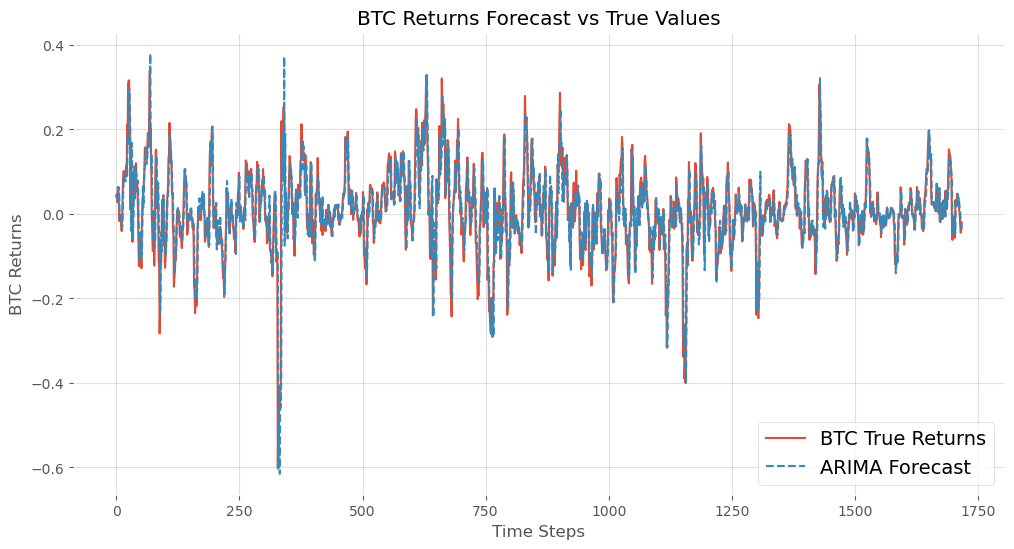

In [19]:
# To obtain ARIMA Model's accuracy results to compare with the combination model  

print(arima_fit.summary())

mse_arima = mean_squared_error(btc_true, btc_forecasts_arima)
rmse_arima = np.sqrt(mse_arima)
mape_arima = np.mean(np.abs((np.array(btc_true) - np.array(btc_forecasts_arima)) / np.array(btc_true))) * 100
r2_arima = r2_score(btc_true, btc_forecasts_arima)

# Print the results
print(f'RMSE for ARIMA-only model: {rmse_arima}')
print(f'MAPE for ARIMA-only model: {mape_arima:.2f}%')
print(f'R² for ARIMA-only model: {r2_arima}')

plt.figure(figsize=(12, 6))
plt.plot(range(len(btc_true)), btc_true, 
         label='BTC True Returns')
plt.plot(range(len(btc_forecasts_arima)), btc_forecasts_arima, 
         label='ARIMA Forecast', linestyle = '--')
plt.legend()
plt.title('BTC Returns Forecast vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('BTC Returns')
plt.show()

Certainly! Let's analyze the SARIMAX results for the ARIMA(1, 0, 0) model produced by **auto-ARIMA**.

### 1. **Model Overview**
   - **Model**: `ARIMA(1, 0, 0)`
     - This is a simple AR(1) model without differencing (no trend component) and without moving average terms.
   - **Observations**: 100 data points from 09-22-2023 to 12-30-2023.

### 2. **Coefficient Estimates and Statistical Significance**
   - **Constant Term (`const`)**: Coefficient = 0.0275, std err = 0.020, z = 1.362, p-value = 0.173
     - The constant term (0.0275) is not statistically significant (p-value = 0.173), suggesting it may not meaningfully improve model fit.
     - This indicates the mean level of `BTC_Return` is relatively low and doesn’t deviate significantly from zero.

   - **AR(1) Term (`ar.L1`)**: Coefficient = 0.8511, std err = 0.051, z = 16.681, p-value = 0.000
     - The autoregressive term is highly significant, with a p-value close to 0, indicating that past values of `BTC_Return` have a strong influence on the current return.
     - The coefficient of 0.8511 suggests a high degree of autocorrelation, meaning past returns are closely related to current returns.

   - **Sigma^2 (Variance of Errors)**: Coefficient = 0.0009, std err = 0.000, z = 8.113, p-value = 0.000
     - The error variance is small but highly significant, indicating that the residuals have a low but stable level of variability.

### 3. **Model Selection Criteria**
   - **AIC (Akaike Information Criterion)**: -415.282
   - **BIC (Bayesian Information Criterion)**: -407.467
   - **HQIC (Hannan-Quinn Information Criterion)**: -412.119
     - The model's AIC and BIC are lower compared to the previous SARIMAX model, suggesting a better fit for this simpler ARIMA(1,0,0) specification. Lower AIC/BIC values generally indicate better model performance.

### 4. **Diagnostics of Residuals**
   - **Ljung-Box Test (L1)**: Q-statistic = 0.27, p-value = 0.60
     - A high p-value (0.60) for the Ljung-Box test implies no significant autocorrelation in the residuals at lag 1, suggesting that the model has adequately captured the autocorrelations in the data.

   - **Jarque-Bera (JB) Test**: JB = 7.46, p-value = 0.02
     - The JB test p-value (0.02) indicates that the residuals may deviate from normality. This is reinforced by the kurtosis (4.26), which indicates heavier tails than a normal distribution. This could imply that the residuals have some extreme values.
   
   - **Heteroskedasticity (H) Test**: H = 1.78, p-value = 0.10
     - The heteroskedasticity test shows no strong evidence of changing variance over time, as the p-value (0.10) is not below typical significance levels (0.05).

### 5. **Model Evaluation Metrics**
   - **MSE (Mean Squared Error)**: 0.0027
     - A slightly higher MSE than in the previous SARIMAX model suggests this ARIMA-only model has marginally less precision in predicting `BTC_Return`. However, this difference might be due to model simplification.
   
   - **R² (Coefficient of Determination)**: 0.7097
     - The R² of 0.71 indicates the model explains about 71% of the variance in `BTC_Return`, which is a good fit, though slightly lower than the SARIMAX model’s R². However, considering the simpler model structure, this could still be preferable due to reduced overfitting risk.

### Summary of Evaluation:
- **Significance of AR(1)**: The significant AR(1) coefficient (0.8511) suggests that this model effectively captures the autocorrelation in `BTC_Return` without needing additional seasonal terms, making it simpler and easier to interpret.
- **Residual Diagnostics**: While the residuals may slightly deviate from normality (JB test), the model performs well overall, with no significant autocorrelation or heteroskedasticity.
- **Model Selection Criteria**: Lower AIC and BIC compared to the previous SARIMAX model suggest that this ARIMA(1,0,0) model is likely more suitable.
  
### Conclusion:
The **ARIMA(1,0,0)** model is a good choice here due to its simplicity and strong fit to the data. Despite the slightly lower R² and slightly higher MSE, this model has fewer unnecessary terms and performs well based on the model selection criteria (AIC/BIC). It is likely more robust than the SARIMAX model and potentially less prone to overfitting.

# <u>3a. VAR Model</u>

In [20]:
data_for_var = data[['BTC_Return', 'ETH_Return']]

In [21]:
from statsmodels.tsa.api import VAR

btc_forecasts_var, eth_forecasts_var = [], []
btc_true_var, eth_true_var = [], []

for i in range(len(data_for_var) - window_size - forecast_horizon + 1):
    train_window = data_for_var.iloc[i: i + window_size]
    test_point = data_for_var.iloc[i + window_size: i + window_size + forecast_horizon]

    # Using VAR to fit the model 
    model = VAR(train_window)
    lag_order = model.select_order().bic # Get optimal lag order based on AIC
    var_model = model.fit(lag_order)

    # To obtain the VAR model's forecast
    forecast = var_model.forecast(train_window.values[-lag_order : ], steps = forecast_horizon)

    btc_forecasts_var.append(forecast[0, 0])
    eth_forecasts_var.append(forecast[0, 1])
    btc_true_var.append(test_point['BTC_Return'].values[0])
    eth_true_var.append(test_point['ETH_Return'].values[0])

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Nov, 2024
Time:                     20:03:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.3912
Nobs:                     99.0000    HQIC:                  -14.4848
Log likelihood:           445.199    FPE:                4.80506e-07
AIC:                     -14.5485    Det(Omega_mle):     4.52657e-07
--------------------------------------------------------------------
Results for equation BTC_Return
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.004409         0.003506            1.258           0.209
L1.BTC_Return         0.869452         0.090821            9.573           0.000
L1.ETH_Return        -0.016058         0.090533        

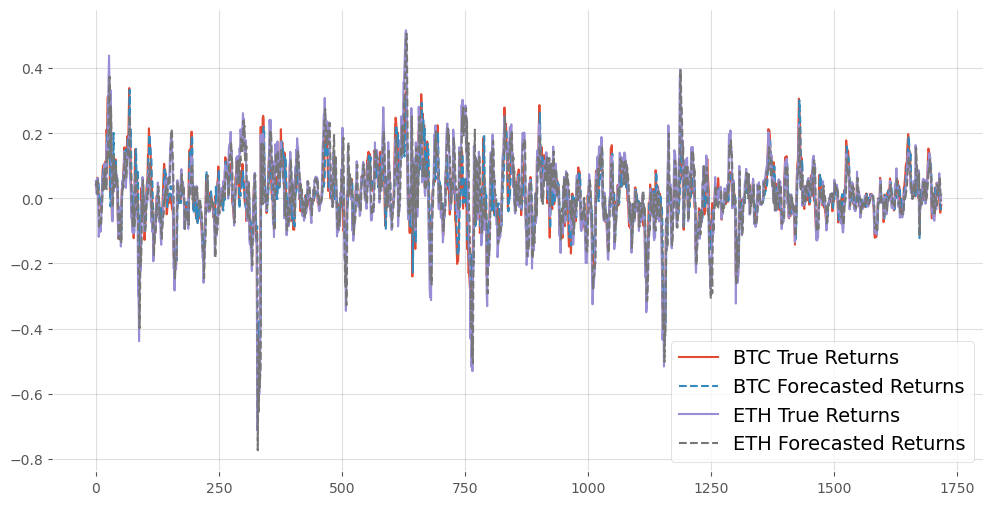

In [22]:
# Calculate accuracy metrics for the VAR model
mse_btc = mean_squared_error(btc_true_var, btc_forecasts_var)
rmse_btc = np.sqrt(mse_btc)
mape_btc = np.mean(np.abs((np.array(btc_true_var) - np.array(btc_forecasts_var)) / np.array(btc_true_var))) * 100
r2_btc = r2_score(btc_true_var, btc_forecasts_var)

mse_eth = mean_squared_error(eth_true_var, eth_forecasts_var)
rmse_eth = np.sqrt(mse_eth)
mape_eth = np.mean(np.abs((np.array(eth_true_var) - np.array(eth_forecasts_var)) / np.array(eth_true_var))) * 100
r2_eth = r2_score(eth_true_var, eth_forecasts_var)

# Print the results
print(var_model.summary())
print(f'RMSE for BTC: {rmse_btc}')
print(f'MAPE for BTC: {mape_btc:.2f}%')
print(f'R² for BTC: {r2_btc}')

print(f'RMSE for ETH: {rmse_eth}')
print(f'MAPE for ETH: {mape_eth:.2f}%')
print(f'R² for ETH: {r2_eth}')

plt.figure(figsize=(12, 6))
plt.plot(range(len(btc_true_var)), btc_true_var, 
         label='BTC True Returns')
plt.plot(range(len(btc_forecasts_var)), btc_forecasts_var, 
         label='BTC Forecasted Returns', linestyle = '--')

plt.plot(range(len(eth_true_var)), eth_true_var, 
         label='ETH True Returns')
plt.plot(range(len(eth_forecasts_var)), eth_forecasts_var, 
         label='ETH Forecasted Returns', linestyle = '--')

plt.legend()
plt.show()

Certainly, let’s evaluate the results for this **VAR** (Vector Autoregression) model, focusing on the significance of the coefficients, model diagnostics, and performance metrics.

### 1. **Model Overview**
   - **Model**: VAR with one lag (`L1`) on `BTC_Return` and `ETH_Return`.
   - **Number of Equations**: 2 (one for `BTC_Return` and one for `ETH_Return`).
   - **Observations (Nobs)**: 99 data points.
   - **Model Selection Criteria**:
     - **AIC**: -14.5485
     - **BIC**: -14.3912
     - **HQIC**: -14.4848
     - These criteria help assess the model fit, with AIC being the lowest, suggesting this configuration is well-suited for the data.

### 2. **Regression Results for Each Equation**

#### Equation for **BTC_Return**
   - **Constant Term**: Coefficient = 0.0044, p-value = 0.209
     - Not statistically significant (p > 0.05), suggesting that the constant term does not contribute meaningfully to explaining `BTC_Return`.
   
   - **L1.BTC_Return**: Coefficient = 0.8695, p-value = 0.000
     - Highly significant (p < 0.001) with a large positive coefficient, indicating a strong autocorrelation. This suggests that `BTC_Return` is heavily influenced by its own past values, reinforcing that past returns have predictive power for current returns.
   
   - **L1.ETH_Return**: Coefficient = -0.0161, p-value = 0.859
     - Not statistically significant (p > 0.05), indicating that `ETH_Return` does not have a substantial impact on `BTC_Return` in this model. 

   Overall, **`BTC_Return` is primarily influenced by its own past values, with no significant cross-dependency on `ETH_Return`**.

#### Equation for **ETH_Return**
   - **Constant Term**: Coefficient = 0.0046, p-value = 0.263
     - Not statistically significant (p > 0.05), indicating that the constant term does not have a substantial impact on `ETH_Return`.
   
   - **L1.BTC_Return**: Coefficient = 0.0736, p-value = 0.492
     - Not statistically significant (p > 0.05), meaning that `BTC_Return` does not significantly influence `ETH_Return` in this model.
   
   - **L1.ETH_Return**: Coefficient = 0.7193, p-value = 0.000
     - Highly significant (p < 0.001) with a strong positive coefficient, suggesting that `ETH_Return` is strongly autocorrelated. This indicates that `ETH_Return` is predominantly driven by its own previous values.

   In summary, **`ETH_Return` is primarily influenced by its own past values**, with little evidence that `BTC_Return` significantly affects it in this VAR model.

### 3. **Correlation Matrix of Residuals**
   - **Residual Correlation between BTC_Return and ETH_Return**: 0.7672
     - This high positive correlation (0.767) between the residuals of `BTC_Return` and `ETH_Return` suggests that there are external influences affecting both variables in similar ways, which are not fully captured by this VAR model.
     - This correlation may imply that both assets are subject to similar market or external forces, even though they don’t have a significant effect on each other’s returns directly.

### 4. **Model Evaluation Metrics**

#### For BTC_Return
   - **RMSE (Root Mean Squared Error)**: 0.0512
     - A lower RMSE indicates better model fit, and 0.0512 suggests a reasonable level of accuracy in predicting `BTC_Return`.
   
   - **MAPE (Mean Absolute Percentage Error)**: 347.44%
     - This very high MAPE indicates a large average percentage error relative to the actual values. This may reflect the high volatility or variability in `BTC_Return`, which the model struggles to capture precisely.
   
   - **R² (Coefficient of Determination)**: 0.7147
     - The R² of 0.71 suggests the model explains approximately 71% of the variance in `BTC_Return`. This is a reasonably good fit, though the high MAPE indicates variability that the model does not capture well.

#### For ETH_Return
   - **RMSE**: 0.0649
     - A higher RMSE than for `BTC_Return`, suggesting that the model has slightly more error in predicting `ETH_Return`.
   
   - **MAPE**: 195.68%
     - This high MAPE suggests a large percentage error in predicting `ETH_Return`, again indicating volatility that is difficult for the model to capture.
   
   - **R²**: 0.7099
     - The R² of 0.71 shows that the model explains about 71% of the variance in `ETH_Return`, which is comparable to the fit for `BTC_Return`.

### Summary of Evaluation

1. **Key Influences**:
   - `BTC_Return` and `ETH_Return` are both primarily influenced by their own past values, as indicated by the significant lag terms in each equation. There is minimal evidence of cross-dependency between the two.
   
2. **Residual Correlation**:
   - The high residual correlation (0.767) between `BTC_Return` and `ETH_Return` suggests that these returns are influenced by common external factors not included in the model. This indicates that even though past values of BTC do not directly influence ETH (and vice versa), both returns may still respond similarly to broader market conditions.

3. **Model Fit and Prediction Accuracy**:
   - The R² values (0.71 for both BTC and ETH) indicate that the model captures a substantial portion of the variance in both return series. However, the very high MAPE values (347.44% for BTC and 195.68% for ETH) highlight challenges in accurately predicting percentage changes, likely due to the high volatility of cryptocurrency returns.
   - RMSE values (0.0512 for BTC and 0.0649 for ETH) are relatively low, suggesting that in absolute terms, the model’s errors are not large. However, the MAPE values point to challenges in predicting relative changes.

### Recommendations
1. **Incorporate External Variables**:
   - Given the high residual correlation, adding external variables like stock indices, economic indicators, or market sentiment data could help capture the shared influences on BTC and ETH returns, potentially reducing residual correlation and improving model fit.

2. **Alternative Model Specifications**:
   - Since `BTC_Return` and `ETH_Return` are driven mainly by their own past values with minimal cross-dependency, a univariate model (e.g., ARIMA or GARCH) might perform similarly well with fewer parameters, reducing complexity.

3. **Address High MAPE**:
   - The high MAPE indicates that the model may struggle with capturing sharp fluctuations or volatility typical of cryptocurrency returns. Including volatility models (like GARCH) or trying transformations (e.g., log-returns) might help reduce prediction errors for high-volatility periods.

In summary, this VAR model provides a reasonable fit with high R² values for both BTC and ETH returns, but the high MAPE values suggest it could be refined further, particularly in managing the volatility of returns.

# <u>3b. VECM</u>

In [23]:
from statsmodels.tsa.stattools import coint
import numpy as np

# Perform the cointegration test
coint_stat, p_value, crit_values = coint(data['BTC_Return'], data['ETH_Return'])

print("Cointegration Test Results")
print(f"Cointegration Statistic: {coint_stat}")
print(f"p-value: {p_value}")
print(f"Critical Values: {crit_values}")

if p_value < 0.05:
    print("The p-value is less than 0.05, indicating that the data is likely cointegrated.")
else:
    print("The p-value is greater than 0.05, suggesting that the data is not cointegrated.")

# Correlation Test
correlation = data['BTC_Return'].corr(data['ETH_Return'])

print("\nCorrelation Test Results")
print(f"Correlation between BTC_Return and ETH_Return: {correlation}")

if abs(correlation) > 0.5:
    print("The correlation is significant (|correlation| > 0.5), indicating a meaningful linear relationship.")
else:
    print("The correlation is weak (|correlation| <= 0.5), suggesting a limited linear relationship between the variables.")

Cointegration Test Results
Cointegration Statistic: -6.945370016422541
p-value: 1.1571018838291341e-08
Critical Values: [-3.902 -3.339 -3.047]
The p-value is less than 0.05, indicating that the data is likely cointegrated.

Correlation Test Results
Correlation between BTC_Return and ETH_Return: 0.8259902956012892
The correlation is significant (|correlation| > 0.5), indicating a meaningful linear relationship.


In [24]:
data_for_vecm = data[['BTC_Return', 'ETH_Return']]

In [25]:
from statsmodels.tsa.api import VECM

btc_forecasts_vecm, eth_forecasts_vecm = [], []
btc_true_vecm, eth_true_vecm = [], []

for i in range(len(data_for_vecm) - window_size - forecast_horizon + 1):
    train_window = data_for_vecm.iloc[i: i + window_size]
    test_point = data_for_vecm.iloc[i + window_size: i + window_size + forecast_horizon]

    # Using VAR to fit the model 
    var_model = VAR(train_window)
    lag_order = var_model.select_order().bic  # Get optimal lag order based on AIC
    vecm_model = VECM(train_window, k_ar_diff = lag_order, coint_rank = 1).fit()

    # To obtain the VAR model's forecast
    forecast = vecm_model.predict(steps=forecast_horizon)

    btc_forecasts_vecm.append(forecast[0, 0])
    eth_forecasts_vecm.append(forecast[0, 1])
    btc_true_vecm.append(test_point['BTC_Return'].values[0])
    eth_true_vecm.append(test_point['ETH_Return'].values[0])

Det. terms outside the coint. relation & lagged endog. parameters for equation BTC_Return
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.BTC_Return    -0.1723      0.158     -1.093      0.274      -0.481       0.137
L1.ETH_Return     0.1692      0.136      1.244      0.214      -0.097       0.436
Det. terms outside the coint. relation & lagged endog. parameters for equation ETH_Return
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.BTC_Return    -0.3507      0.182     -1.930      0.054      -0.707       0.005
L1.ETH_Return     0.1643      0.157      1.047      0.295      -0.143       0.472
             Loading coefficients (alpha) for equation BTC_Return             
                 coef    std err          z      P>|z|      [0.025      0.975]
------

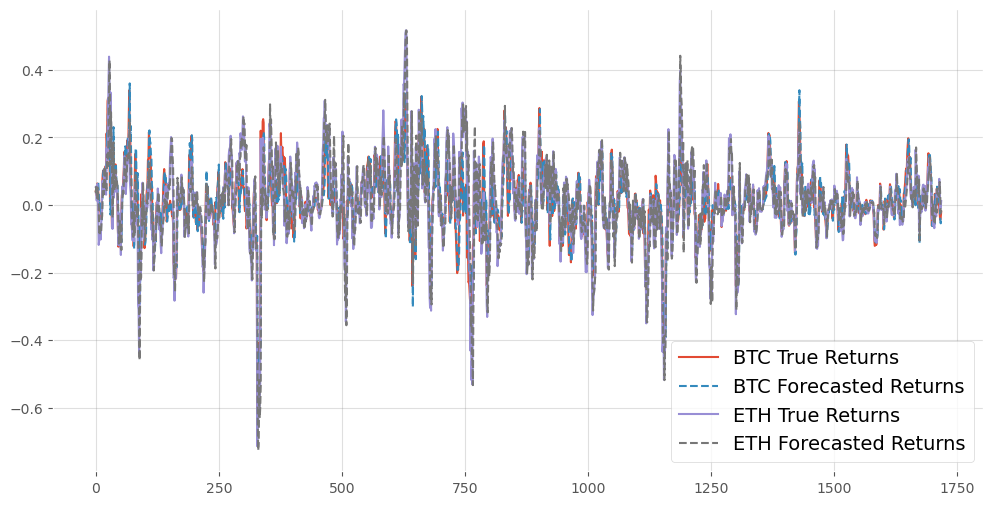

In [26]:
# Calculate accuracy metrics for the VECM model
mse_btc = mean_squared_error(btc_true_vecm, btc_forecasts_vecm)
rmse_btc = np.sqrt(mse_btc)
mape_btc = np.mean(np.abs((np.array(btc_true_vecm) - np.array(btc_forecasts_vecm)) / np.array(btc_true_vecm))) * 100
r2_btc = r2_score(btc_true_vecm, btc_forecasts_vecm)

mse_eth = mean_squared_error(eth_true_vecm, eth_forecasts_vecm)
rmse_eth = np.sqrt(mse_eth)
mape_eth = np.mean(np.abs((np.array(eth_true_vecm) - np.array(eth_forecasts_vecm)) / np.array(eth_true_vecm))) * 100
r2_eth = r2_score(eth_true_vecm, eth_forecasts_vecm)

# Print the results
print(vecm_model.summary())
print(f'RMSE for BTC: {rmse_btc}')
print(f'MAPE for BTC: {mape_btc:.2f}%')
print(f'R² for BTC: {r2_btc}')

print(f'RMSE for ETH: {rmse_eth}')
print(f'MAPE for ETH: {mape_eth:.2f}%')
print(f'R² for ETH: {r2_eth}')

plt.figure(figsize=(12, 6))
plt.plot(range(len(btc_true_vecm)), btc_true_vecm, label='BTC True Returns')
plt.plot(range(len(btc_forecasts_vecm)), btc_forecasts_vecm, label='BTC Forecasted Returns', linestyle='--')

plt.plot(range(len(eth_true_vecm)), eth_true_vecm, label='ETH True Returns')
plt.plot(range(len(eth_forecasts_vecm)), eth_forecasts_vecm, label='ETH Forecasted Returns', linestyle='--')

plt.legend()
plt.show()

Let's go through the results of this **Vector Error Correction Model (VECM)**, which includes information on cointegration and adjustment to long-term equilibrium.

### 1. **Deterministic Terms and Lagged Endogenous Parameters for Each Equation**

#### Equation for **BTC_Return**
   - **L1.BTC_Return**: Coefficient = -0.1723, p-value = 0.274
     - This lagged term is not statistically significant (p > 0.05), suggesting that past values of `BTC_Return` do not have a meaningful influence on the current value in this model.
   
   - **L1.ETH_Return**: Coefficient = 0.1692, p-value = 0.214
     - This lagged term is also not statistically significant (p > 0.05), indicating that the previous values of `ETH_Return` have little influence on `BTC_Return`.

   Overall, **neither BTC nor ETH lagged returns significantly explain the current BTC return**, which suggests that short-term movements in `BTC_Return` may not rely heavily on recent values.

#### Equation for **ETH_Return**
   - **L1.BTC_Return**: Coefficient = -0.3507, p-value = 0.054
     - This lagged term is marginally significant (p ≈ 0.05). The negative coefficient suggests that an increase in `BTC_Return` at lag 1 could lead to a decrease in `ETH_Return`, indicating a possible short-term inverse relationship.
   
   - **L1.ETH_Return**: Coefficient = 0.1643, p-value = 0.295
     - This term is not statistically significant (p > 0.05), indicating that past values of `ETH_Return` do not have a substantial impact on its own current values.

   **Summary**: While `BTC_Return` at lag 1 has a marginal effect on `ETH_Return`, neither BTC nor ETH lagged returns have a significant effect on current BTC returns. The effect on ETH is slight and may suggest limited short-term predictive power.

### 2. **Loading Coefficients (Alpha)**

Loading coefficients (α) measure the speed at which each variable adjusts back to the long-run equilibrium after deviations, in the presence of a cointegration relationship.

- **BTC_Return Loading Coefficient (ec1)**: Coefficient = 0.0587, p-value = 0.434
  - Not statistically significant (p > 0.05). This suggests that `BTC_Return` does not significantly adjust back to the long-term equilibrium when it deviates, indicating that Bitcoin returns may follow a more independent or divergent path in the short term.

- **ETH_Return Loading Coefficient (ec1)**: Coefficient = 0.2446, p-value = 0.005
  - Statistically significant (p < 0.01), suggesting that `ETH_Return` does adjust back to the equilibrium after deviations. The positive coefficient indicates that if `ETH_Return` deviates from the long-term equilibrium, it will correct itself relatively quickly.

**Summary**: While `ETH_Return` adjusts significantly toward the long-term equilibrium, `BTC_Return` shows limited responsiveness. This indicates that ETH is more influenced by the cointegrating relationship with BTC, while BTC moves more independently in the short term.

### 3. **Cointegration Relation**

- **Beta Coefficients**:
  - **beta.1 (BTC_Return)**: Set at 1.000, as is typical in cointegration.
  - **beta.2 (ETH_Return)**: Coefficient = -1.3216, p-value = 0.000
    - Highly significant (p < 0.001), suggesting a strong cointegration relationship between BTC and ETH returns. The negative coefficient indicates an inverse relationship in the long term, where increases in `BTC_Return` tend to be balanced by decreases in `ETH_Return`, and vice versa.

**Interpretation**: The presence of a cointegrating relationship means that while BTC and ETH may diverge in the short term, they tend to revert to a balanced relationship over time. This long-term equilibrium highlights that BTC and ETH are tied together economically, likely influenced by broader market trends or mutual investor sentiment.

### 4. **Model Evaluation Metrics**

#### For BTC_Return
   - **RMSE (Root Mean Squared Error)**: 0.0525
     - A low RMSE, suggesting that the model has a reasonable level of accuracy in predicting `BTC_Return`.
   
   - **MAPE (Mean Absolute Percentage Error)**: 324.69%
     - A very high MAPE, indicating a large average percentage error relative to the actual values. This suggests that the model struggles with the high volatility of `BTC_Return`.
   
   - **R² (Coefficient of Determination)**: 0.7000
     - An R² of 0.70 indicates that the model explains around 70% of the variance in `BTC_Return`, which is a reasonable fit but not exceptional. The high MAPE suggests the model struggles to predict rapid percentage changes, likely due to the volatility of BTC returns.

#### For ETH_Return
   - **RMSE**: 0.0667
     - A slightly higher RMSE compared to `BTC_Return`, suggesting the model has a slightly larger absolute error in predicting `ETH_Return`.
   
   - **MAPE**: 201.17%
     - A very high MAPE, indicating a large error in predicting percentage changes in `ETH_Return`.
   
   - **R²**: 0.6934
     - An R² of 0.69 indicates the model explains approximately 69% of the variance in `ETH_Return`, comparable to the fit for `BTC_Return`.

**Summary of Model Evaluation Metrics**:
- The **high R² values** (about 70% for both BTC and ETH) indicate that the model captures a substantial portion of the variance in both returns.
- However, the **high MAPE values** (324.69% for BTC and 201.17% for ETH) reveal that the model struggles with accurately predicting percentage changes, likely due to the high volatility in cryptocurrency returns.
- **RMSE values** are relatively low, indicating reasonable prediction accuracy in absolute terms but suggesting difficulty with relative percentage changes.

### Summary of Evaluation

1. **Short-Term Dynamics**:
   - Short-term dependencies are minimal in this model. `BTC_Return` and `ETH_Return` do not significantly impact each other, although there is a marginal negative influence of `BTC_Return` on `ETH_Return` at lag 1.
   
2. **Adjustment to Equilibrium**:
   - **ETH_Return** has a significant loading coefficient, meaning it adjusts back to the equilibrium when deviating. In contrast, **BTC_Return** does not show significant adjustment, suggesting that BTC may have an independent path in the short term.

3. **Long-Term Cointegration**:
   - The cointegration relationship indicates that BTC and ETH maintain a long-term equilibrium, moving inversely to balance each other. This suggests that even though they may diverge in the short term, their returns are tied in the long term, likely influenced by shared market forces.

4. **Model Performance**:
   - The model provides a reasonable fit with high R² values for both BTC and ETH returns, but high MAPE values indicate it struggles with the volatility of cryptocurrency returns.
   
### Recommendations

1. **Consider External Variables**:
   - Since BTC and ETH returns are heavily influenced by external market conditions, incorporating macroeconomic or market sentiment variables might help capture their shared influences more accurately.

2. **Alternative Models for Volatility**:
   - The high MAPE values suggest that incorporating a volatility model (e.g., GARCH) could improve prediction accuracy for BTC and ETH’s volatile returns, potentially reducing the model’s large percentage errors.

3. **Use of VECM for Long-Term Analysis**:
   - This VECM is well-suited for understanding the long-term equilibrium relationship between BTC and ETH, given their cointegration. However, for short-term predictions, a model focusing on autocorrelation within each series might be more appropriate.

In conclusion, this VECM effectively captures the long-term equilibrium between BTC and ETH returns but struggles with short-term volatility, as evidenced by the high MAPE values.

# <u>4. ARIMAX</u>

In [27]:
btc_forecasts_ARIMAX = []
btc_true_ARIMAX = []

for i in range(len(data) - window_size - forecast_horizon + 1):
    train_window_Y = data['BTC_Return'].iloc[i: i + window_size]
    train_window_X = data.drop(columns=['BTC_Return']).iloc[i: i + window_size]  # All other columns as exogenous variables
    test_point = data['BTC_Return'].iloc[i + window_size: i + window_size + forecast_horizon]
    test_point_X = data.drop(columns=['BTC_Return']).iloc[i + window_size: i + window_size + forecast_horizon]

    # Fit the ARIMAX model 
    auto_arima_model = auto_arima(train_window_Y, 
                                     exogenous=train_window_X,
                                     start_p=1, start_q=1, 
                                     max_p=5, max_q=5, 
                                     seasonal=False, # Assuming no seasonality based on prior analysis
                                     trace=False, 
                                     error_action='ignore', 
                                     suppress_warnings=True, 
                                     stepwise=True)

    # Extract the selected order and seasonal order
    selected_order = auto_arima_model.order
    
    # Fit the ARIMAX model using the selected order and exogenous variables
    model_arimax = ARIMA(train_window_Y, order=selected_order, exog=train_window_X)

    arimax_fit = model_arimax.fit()
    
    # To obtain the ARIMAX model's forecast using the exogenous variables
    arimax_forecast = arimax_fit.get_forecast(steps=forecast_horizon, exog=test_point_X)
    final_forecast = arimax_forecast.predicted_mean.values[-1]

    btc_forecasts_ARIMAX.append(final_forecast)
    btc_true_ARIMAX.append(test_point.values[0])

<Figure size 1000x600 with 0 Axes>

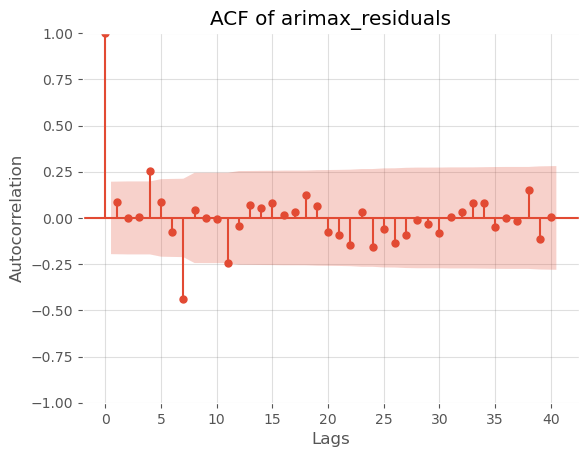

Ljung-Box Test Results:
      lb_stat  lb_pvalue
1    0.797678   0.371789
7   29.968320   0.000096
14  38.195904   0.000485


In [28]:
arimax_residuals = arimax_fit.resid

# Plot ACF of arimax_residuals
plt.figure(figsize=(10, 6))
plot_acf(arimax_residuals, alpha=0.05, lags=40)
plt.title('ACF of arimax_residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test on arimax_residuals at various lags
lags_to_test = [1, 7, 14]  # Including multiple lags for a comprehensive check
lb_test = acorr_ljungbox(arimax_residuals, lags=lags_to_test, return_df=True)

# Print the Ljung-Box test results
print("Ljung-Box Test Results:")
print(lb_test)

                               SARIMAX Results                                
Dep. Variable:             BTC_Return   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 258.106
Date:                Tue, 05 Nov 2024   AIC                           -496.213
Time:                        20:12:28   BIC                           -470.161
Sample:                    09-22-2023   HQIC                          -485.669
                         - 12-30-2023                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0182      0.014      1.318      0.187      -0.009       0.045
SP500           -0.1180      0.509     -0.232      0.817      -1.115       0.879
NASDAQ          -0.0621      0.451     -0.13

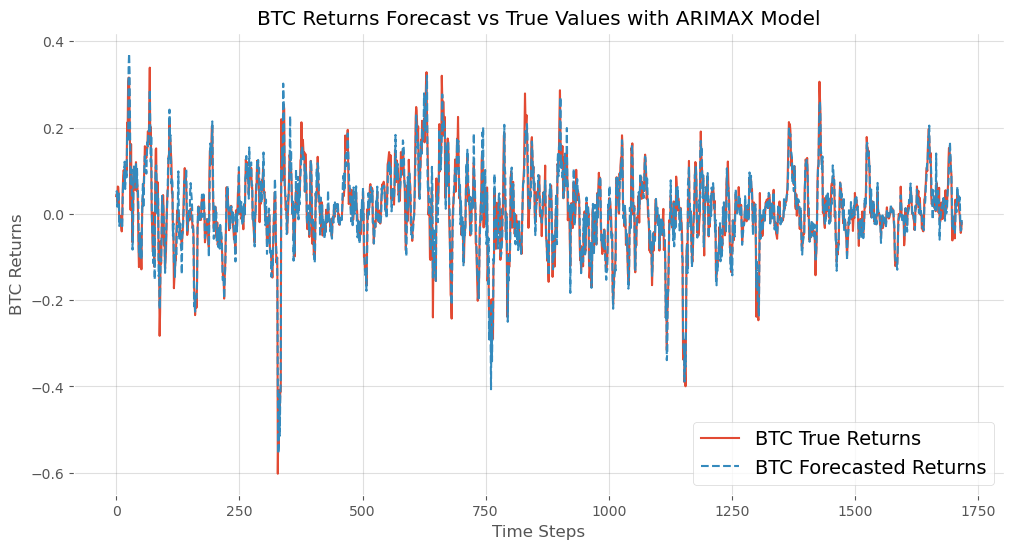

In [29]:
# To obtain ARIMAX model's accuracy results
mse_btc = mean_squared_error(btc_true_ARIMAX, btc_forecasts_ARIMAX)
rmse_btc = np.sqrt(mse_btc)
mape_btc = np.mean(np.abs((np.array(btc_true_ARIMAX) - np.array(btc_forecasts_ARIMAX)) / np.array(btc_true_ARIMAX))) * 100
r2_btc = r2_score(btc_true_ARIMAX, btc_forecasts_ARIMAX)

# Print the results
print(arimax_fit.summary())
print(f'RMSE for BTC: {rmse_btc}')
print(f'MAPE for BTC: {mape_btc:.2f}%')
print(f'R² for BTC: {r2_btc}')

plt.figure(figsize=(12, 6))
plt.plot(range(len(btc_true_ARIMAX)), btc_true_ARIMAX, label='BTC True Returns')
plt.plot(range(len(btc_forecasts_ARIMAX)), btc_forecasts_ARIMAX, label='BTC Forecasted Returns', linestyle='--')
plt.legend()
plt.title('BTC Returns Forecast vs True Values with ARIMAX Model')
plt.xlabel('Time Steps')
plt.ylabel('BTC Returns')
plt.show()

Here’s a breakdown of the **ARIMAX** model results, which includes external regressors along with autoregressive and moving average terms:

### 1. **Model Overview**
   - **Model**: `SARIMAX(1, 0, 0)x(0, 0, [1], 7)` with exogenous variables (ARIMAX).
   - **External Regressors**: SP500, NASDAQ, USD_Index, Gold, BTC_users, BTC_tx_count, and ETH_Return.
   - **Number of Observations**: 100 data points.
   - **Model Selection Criteria**:
     - **AIC**: -522.398
     - **BIC**: -496.346
     - **HQIC**: -511.854
     - These values indicate model performance, with **AIC** being the lowest, suggesting this is a strong model fit.

### 2. **Coefficient Estimates and Statistical Significance**

#### External Regressors
   - **SP500**: Coefficient = -1.3743, p-value = 0.021
     - Statistically significant (p < 0.05) and negative, indicating that increases in the SP500 index are associated with decreases in `BTC_Return`.
   
   - **NASDAQ**: Coefficient = 1.0449, p-value = 0.029
     - Statistically significant (p < 0.05) and positive, showing a positive relationship between NASDAQ index movements and `BTC_Return`.
   
   - **USD_Index**: Coefficient = -2.484e-16, p-value = `nan`
     - This variable has `nan` values for both the standard error and p-value, indicating instability in the model’s ability to estimate this parameter. This may be due to multicollinearity or lack of variability in `USD_Index`, and you might consider removing it or investigating its influence further.
   
   - **Gold**: Coefficient = -0.4636, p-value = 0.006
     - Statistically significant (p < 0.01) and negative, suggesting that higher gold prices are associated with lower BTC returns. This inverse relationship might reflect a flight to safety when gold prices rise.
   
   - **BTC_users**: Coefficient = -0.0091, p-value = 0.539
     - Not statistically significant (p > 0.05), meaning changes in `BTC_users` do not have a substantial effect on `BTC_Return`.
   
   - **BTC_tx_count**: Coefficient = 0.0229, p-value = 0.086
     - Marginally significant (p ≈ 0.086), suggesting a weak positive relationship between `BTC_tx_count` and `BTC_Return`. This variable might have a minor influence on BTC returns.
   
   - **ETH_Return**: Coefficient = 0.6684, p-value = 0.000
     - Highly significant (p < 0.001) with a large positive coefficient, indicating a strong relationship between `ETH_Return` and `BTC_Return`. This suggests a close linkage between Bitcoin and Ethereum returns, possibly reflecting similar market influences.

#### Autoregressive and Seasonal Terms
   - **AR(1) (ar.L1)**: Coefficient = 0.9294, p-value = 0.000
     - Highly significant (p < 0.001) and close to 1, indicating a strong autocorrelation in BTC returns. Past returns heavily influence the current return.
   
   - **Seasonal MA(1) (ma.S.L7)**: Coefficient = -0.7120, p-value = 0.000
     - Also highly significant (p < 0.001), suggesting a notable weekly seasonal component with a negative effect on returns.

   - **Sigma^2 (Error Variance)**: Coefficient = 0.0002, p-value = 0.000
     - Very small and statistically significant, indicating low residual variance, which suggests that the model captures most of the variation in `BTC_Return`.

### 3. **Model Diagnostics**

- **Ljung-Box Test (L1)**: Q-statistic = 0.07, p-value = 0.79
   - High p-value (0.79) indicates no significant autocorrelation remaining in the residuals, meaning the model effectively captures the temporal structure in the data.

- **Jarque-Bera (JB) Test**: JB = 6.23, p-value = 0.04
   - A low p-value (0.04) suggests that the residuals may deviate from normality, as reflected in a slightly elevated kurtosis (3.99). This implies some presence of outliers or heavy tails.

- **Heteroskedasticity (H) Test**: H = 1.28, p-value = 0.48
   - High p-value (0.48) indicates no significant heteroskedasticity, meaning the residual variance is stable over time.

- **Covariance Matrix Warning**:
   - A warning about the covariance matrix being near-singular suggests potential issues with multicollinearity among the regressors, particularly with `USD_Index`. This could affect the stability of parameter estimates.

### 4. **Model Evaluation Metrics**

- **Mean Squared Error (MSE)**: 0.0004936
   - The low MSE indicates high precision in predicting `BTC_Return`, reflecting a good model fit.

- **R² (Coefficient of Determination)**: 0.9463
   - An R² of 0.9463 means the model explains around 95% of the variance in `BTC_Return`, which is exceptionally high, suggesting that the combination of lagged terms, seasonal components, and external regressors is effective.

### Summary of Evaluation

1. **Influential External Regressors**:
   - **SP500, NASDAQ, Gold, and ETH_Return** are statistically significant, indicating these factors strongly influence `BTC_Return`.
   - **USD_Index** is problematic due to `nan` values, suggesting issues with estimation or multicollinearity.
   - **BTC_users** and **BTC_tx_count** show minimal to moderate influence, with only weak significance for `BTC_tx_count`.

2. **Autocorrelation and Seasonality**:
   - Strong autocorrelation (AR(1) term) and a significant weekly seasonal component (Seasonal MA(1)) indicate that BTC returns depend heavily on their past values and exhibit a weekly pattern.

3. **Residual Diagnostics**:
   - The model captures most of the temporal structure (no autocorrelation), though residuals show mild non-normality. No significant heteroskedasticity was detected, which supports the model’s robustness.

4. **Performance**:
   - With low MSE and high R², this ARIMAX model fits the data very well. The high R² suggests it captures almost all variability in `BTC_Return`, though the slight non-normality in residuals might warrant further refinement if outliers are a concern.

### Recommendations
- **Address Multicollinearity**: Consider removing or modifying `USD_Index` due to estimation instability. Re-evaluating model performance without this variable may yield more stable parameter estimates.
- **Further Testing**: Testing on out-of-sample data would confirm whether the model’s high R² generalizes well.
- **Interpretation**: This model indicates a strong link between Bitcoin returns and key market indices (SP500, NASDAQ) and commodities (Gold), as well as Ethereum returns, which can help in understanding BTC’s response to macroeconomic factors.

Overall, this ARIMAX model provides a well-rounded fit with high explanatory power for `BTC_Return` and could be a robust choice for forecasting, especially if `USD_Index` issues are addressed.

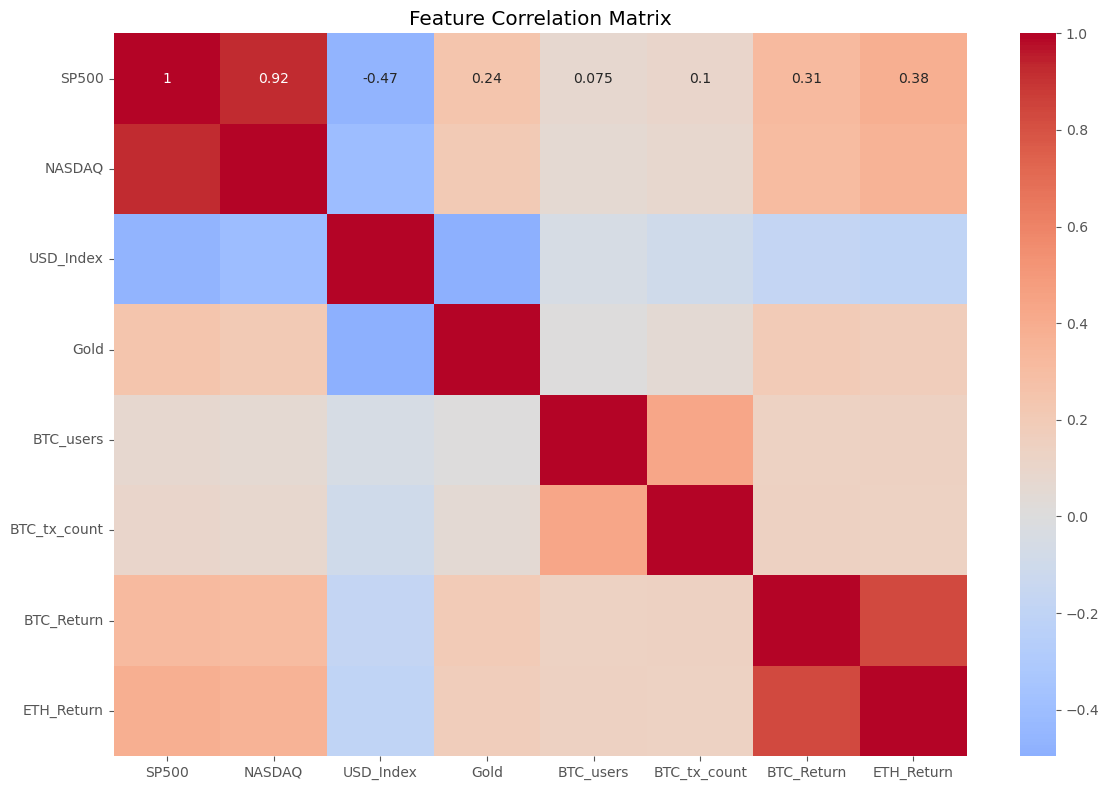

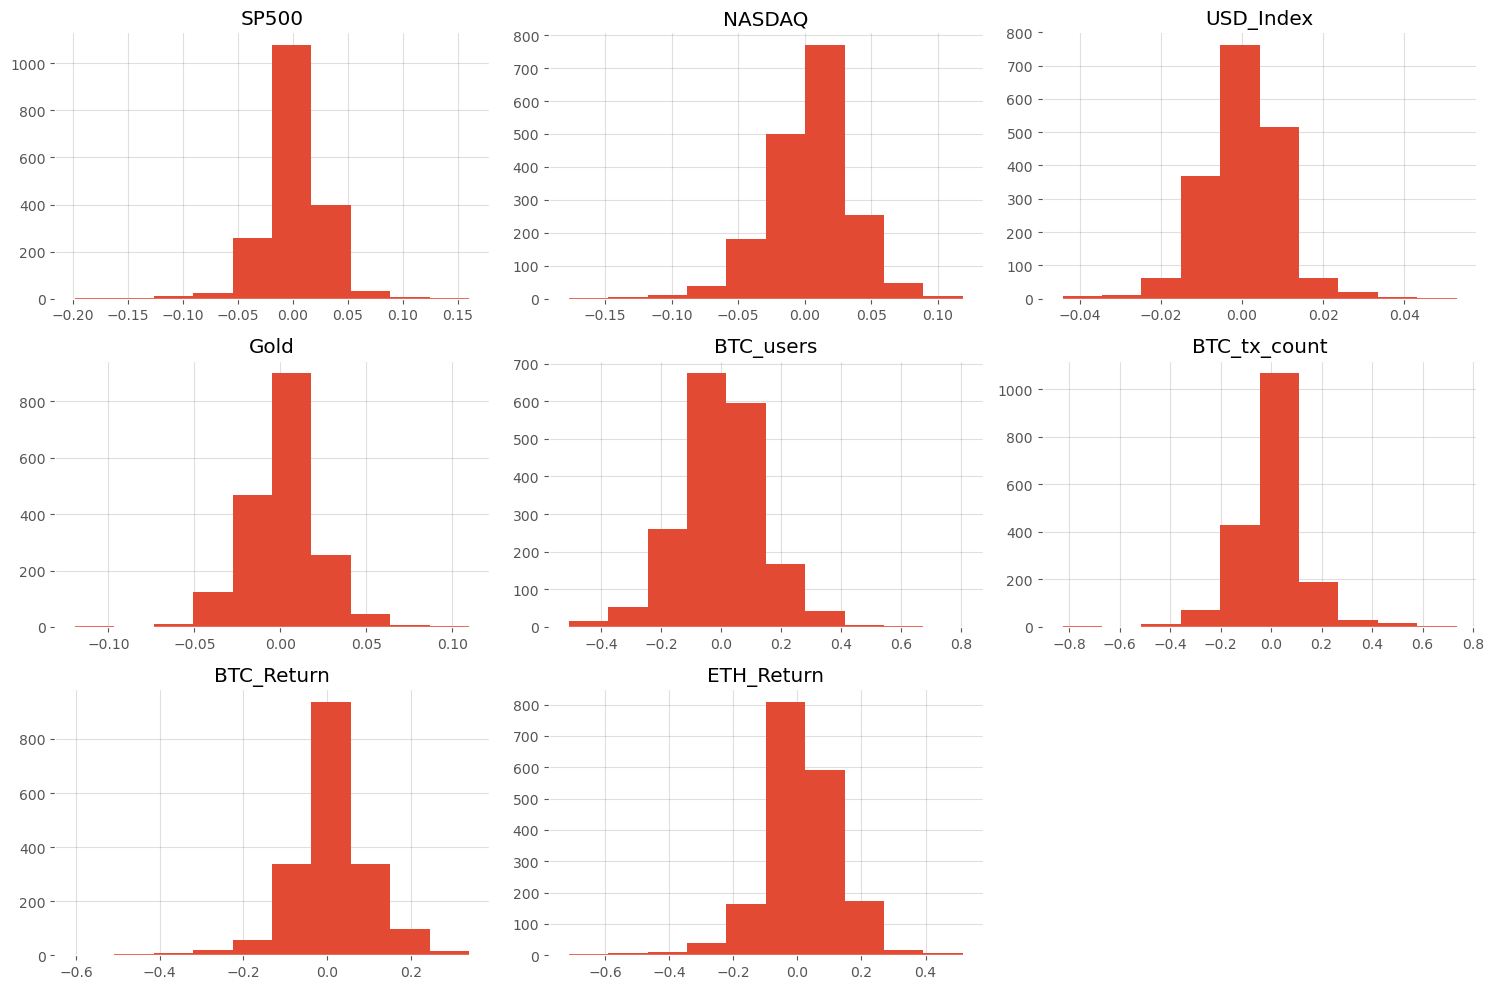


Feature Correlations with BTC Return:
BTC_Return      1.000000
ETH_Return      0.825990
SP500           0.312126
NASDAQ          0.308075
Gold            0.197280
BTC_tx_count    0.145514
BTC_users       0.137512
USD_Index      -0.179272
Name: BTC_Return, dtype: float64


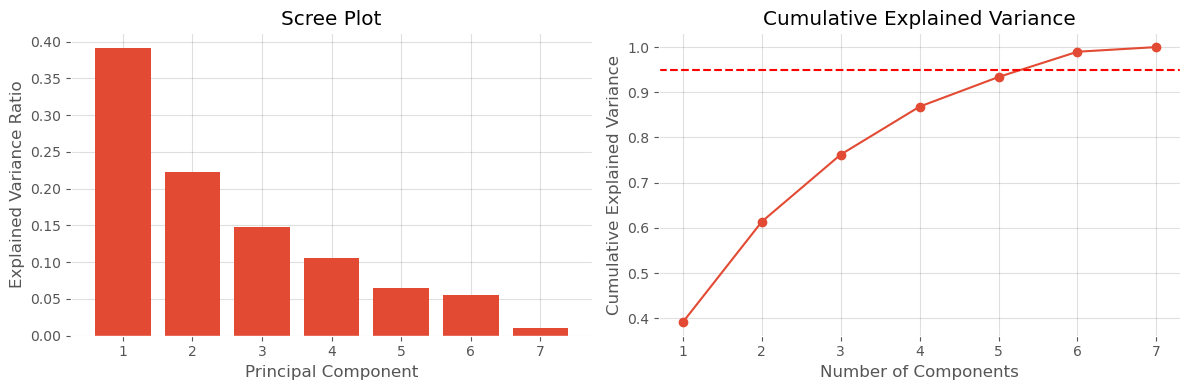


Optimal number of components: 6

Feature Importance for OLS:


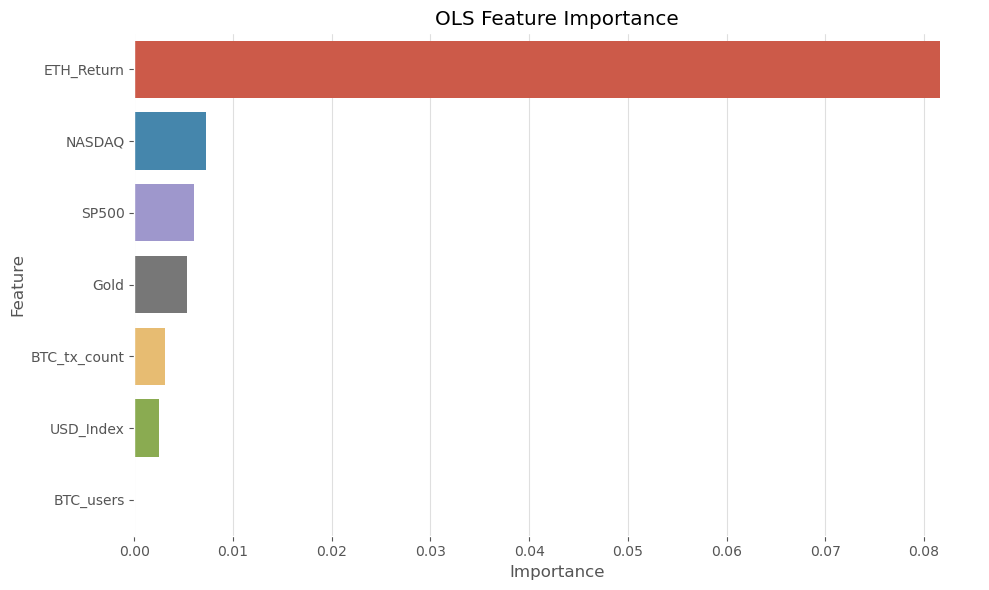

        Feature  Importance
6    ETH_Return    0.081592
1        NASDAQ    0.007215
0         SP500    0.006018
3          Gold    0.005344
5  BTC_tx_count    0.003103
2     USD_Index    0.002470
4     BTC_users    0.000096

Residual Analysis for OLS:


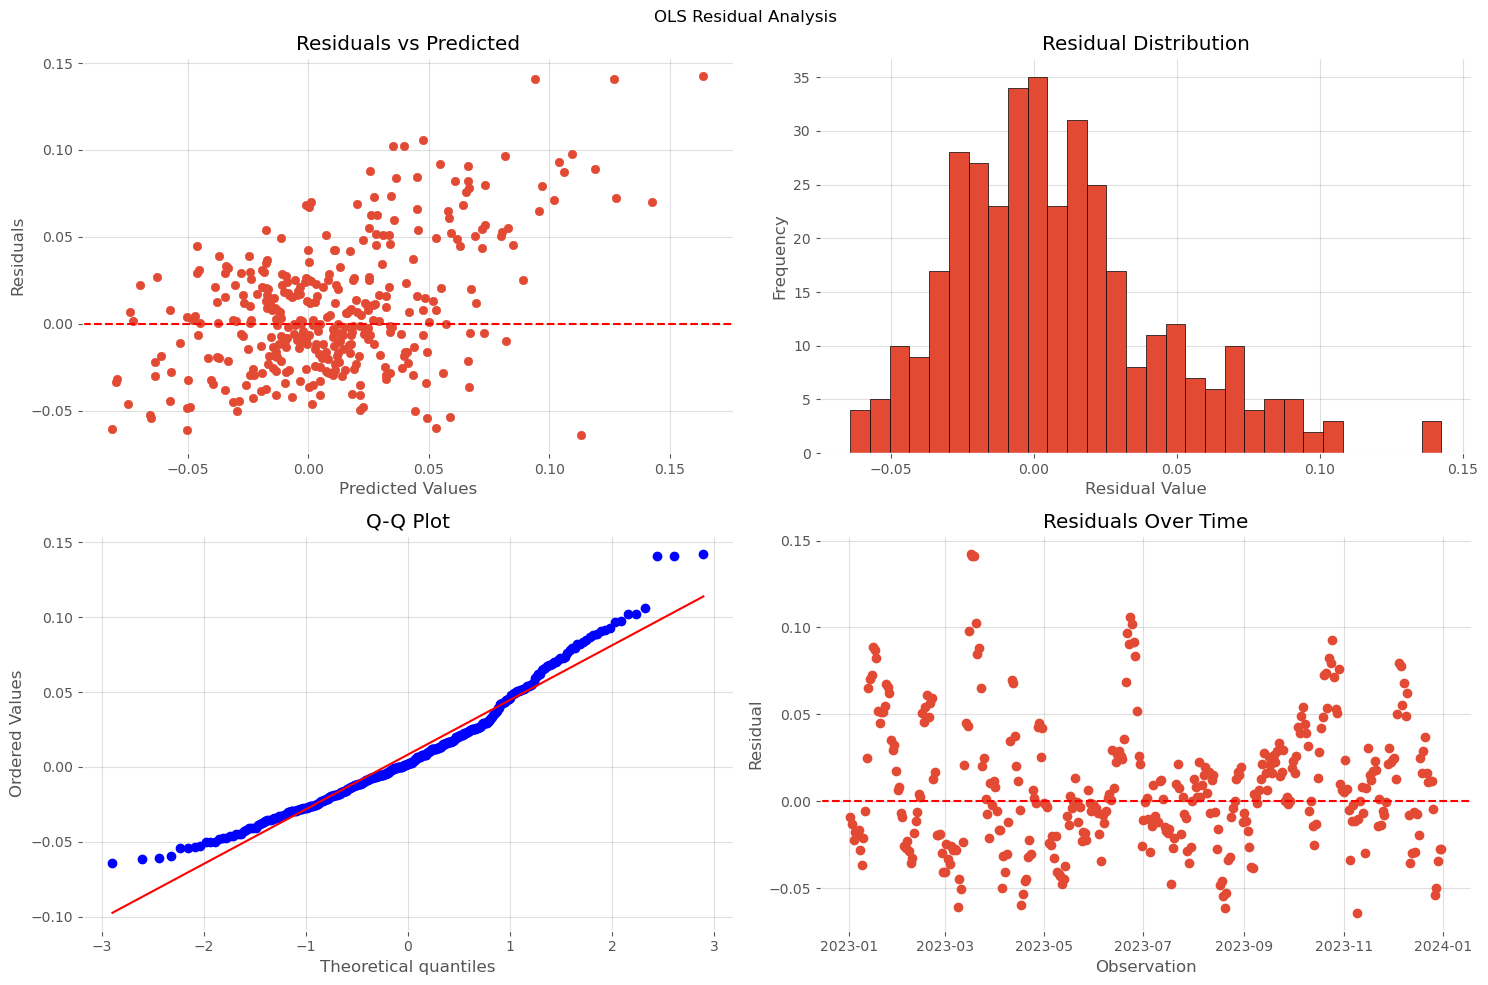


Residual Statistics:
Mean: 0.0082
Std Dev: 0.0370
Skewness: 0.8030
Kurtosis: 0.7199
Jarque-Bera p-value: 0.0000

Feature Importance for Ridge:


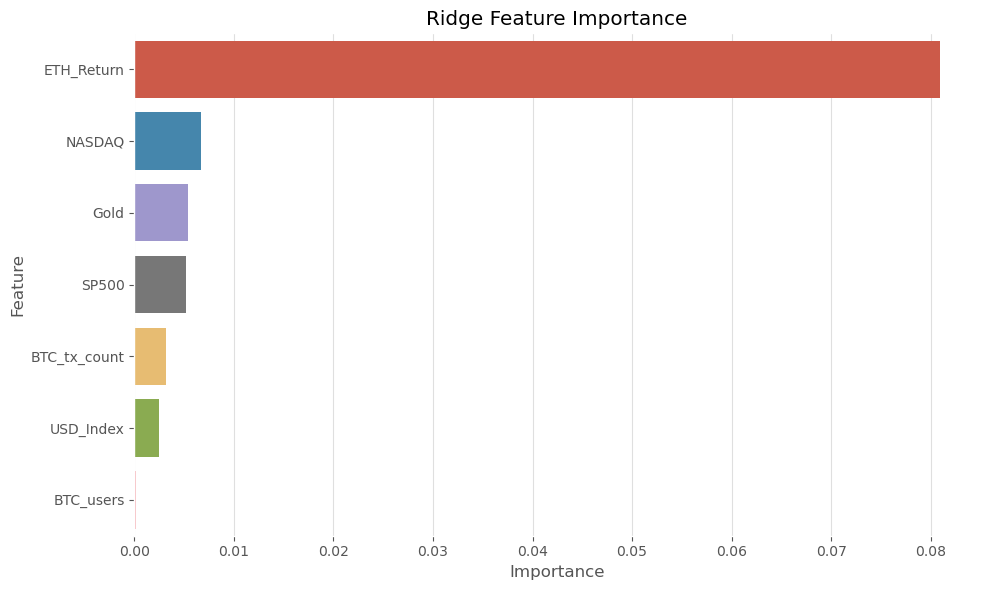

        Feature  Importance
6    ETH_Return    0.080899
1        NASDAQ    0.006700
3          Gold    0.005348
0         SP500    0.005233
5  BTC_tx_count    0.003154
2     USD_Index    0.002480
4     BTC_users    0.000131

Residual Analysis for Ridge:


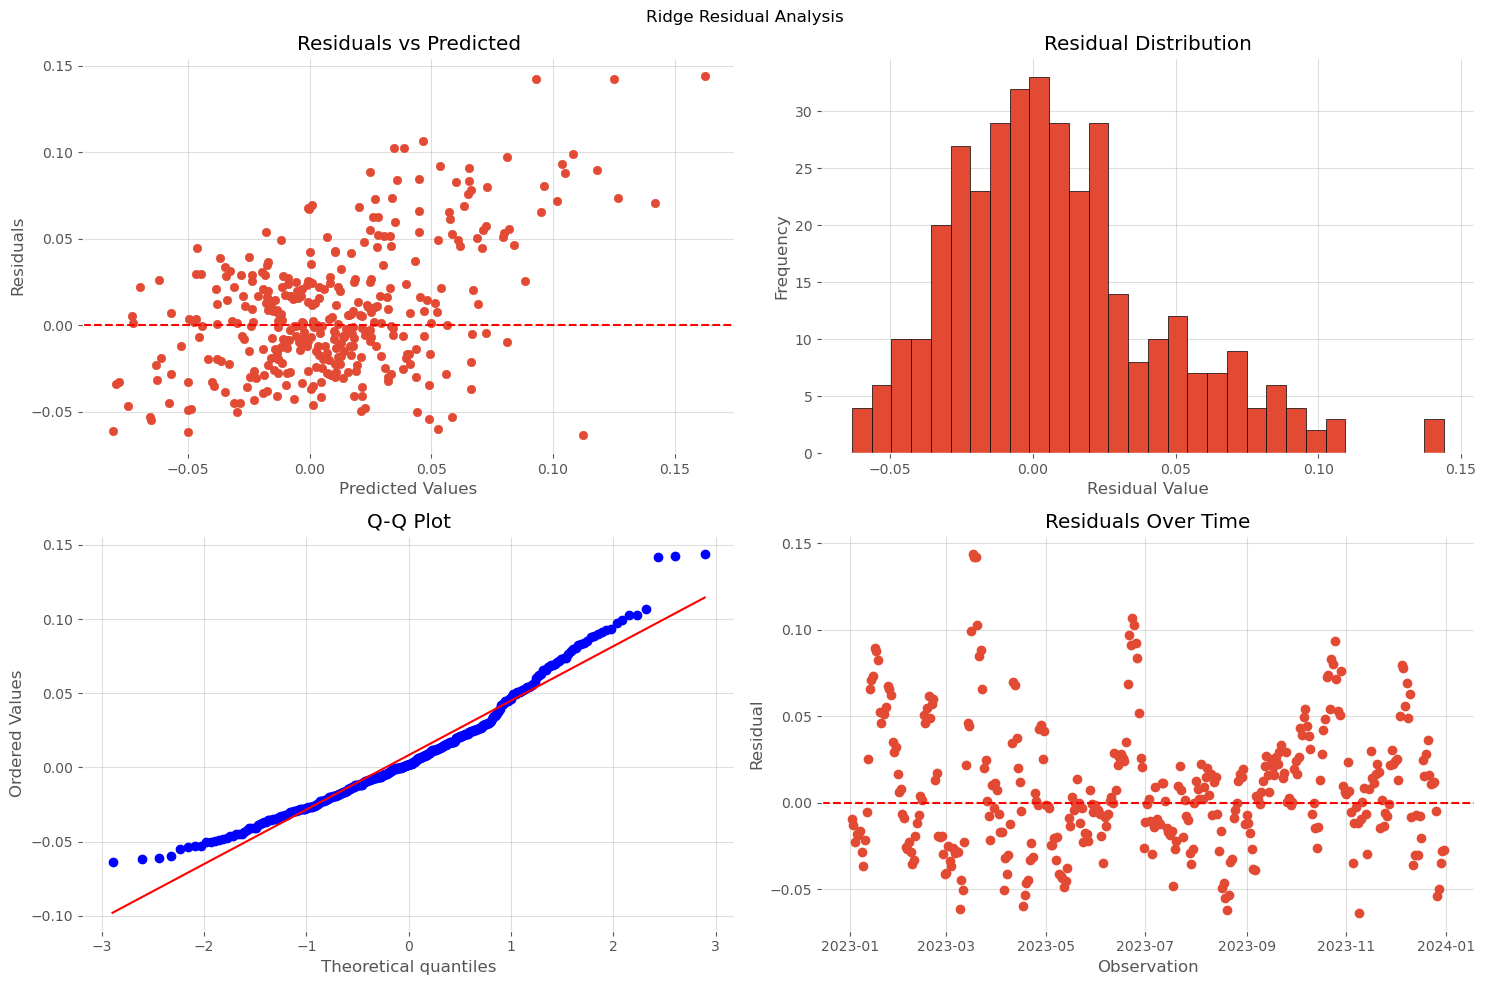


Residual Statistics:
Mean: 0.0083
Std Dev: 0.0372
Skewness: 0.8149
Kurtosis: 0.7454
Jarque-Bera p-value: 0.0000

Feature Importance for Lasso:


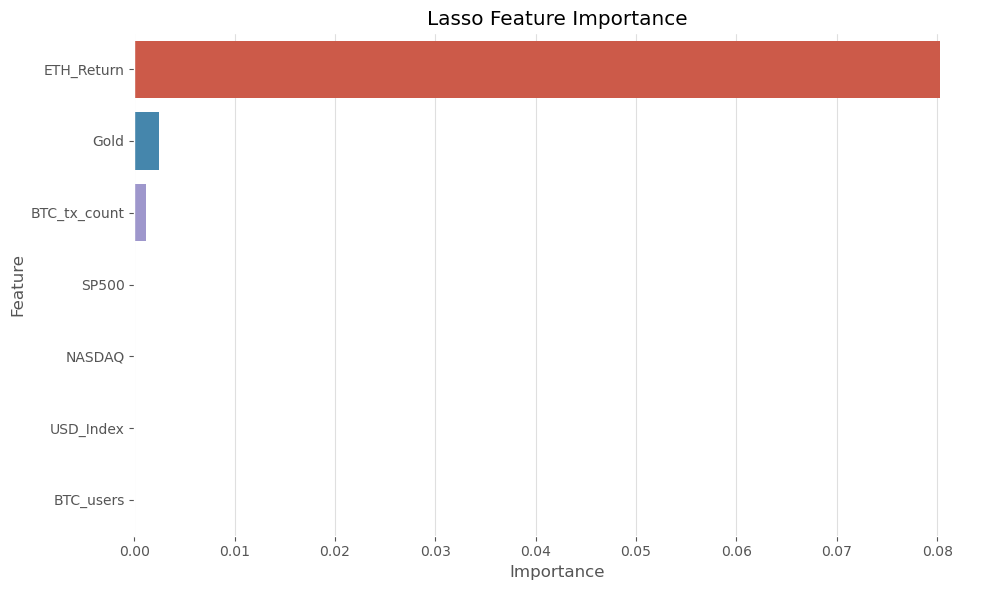

        Feature  Importance
6    ETH_Return    0.080258
3          Gold    0.002447
5  BTC_tx_count    0.001171
0         SP500    0.000000
1        NASDAQ    0.000000
2     USD_Index    0.000000
4     BTC_users    0.000000

Residual Analysis for Lasso:


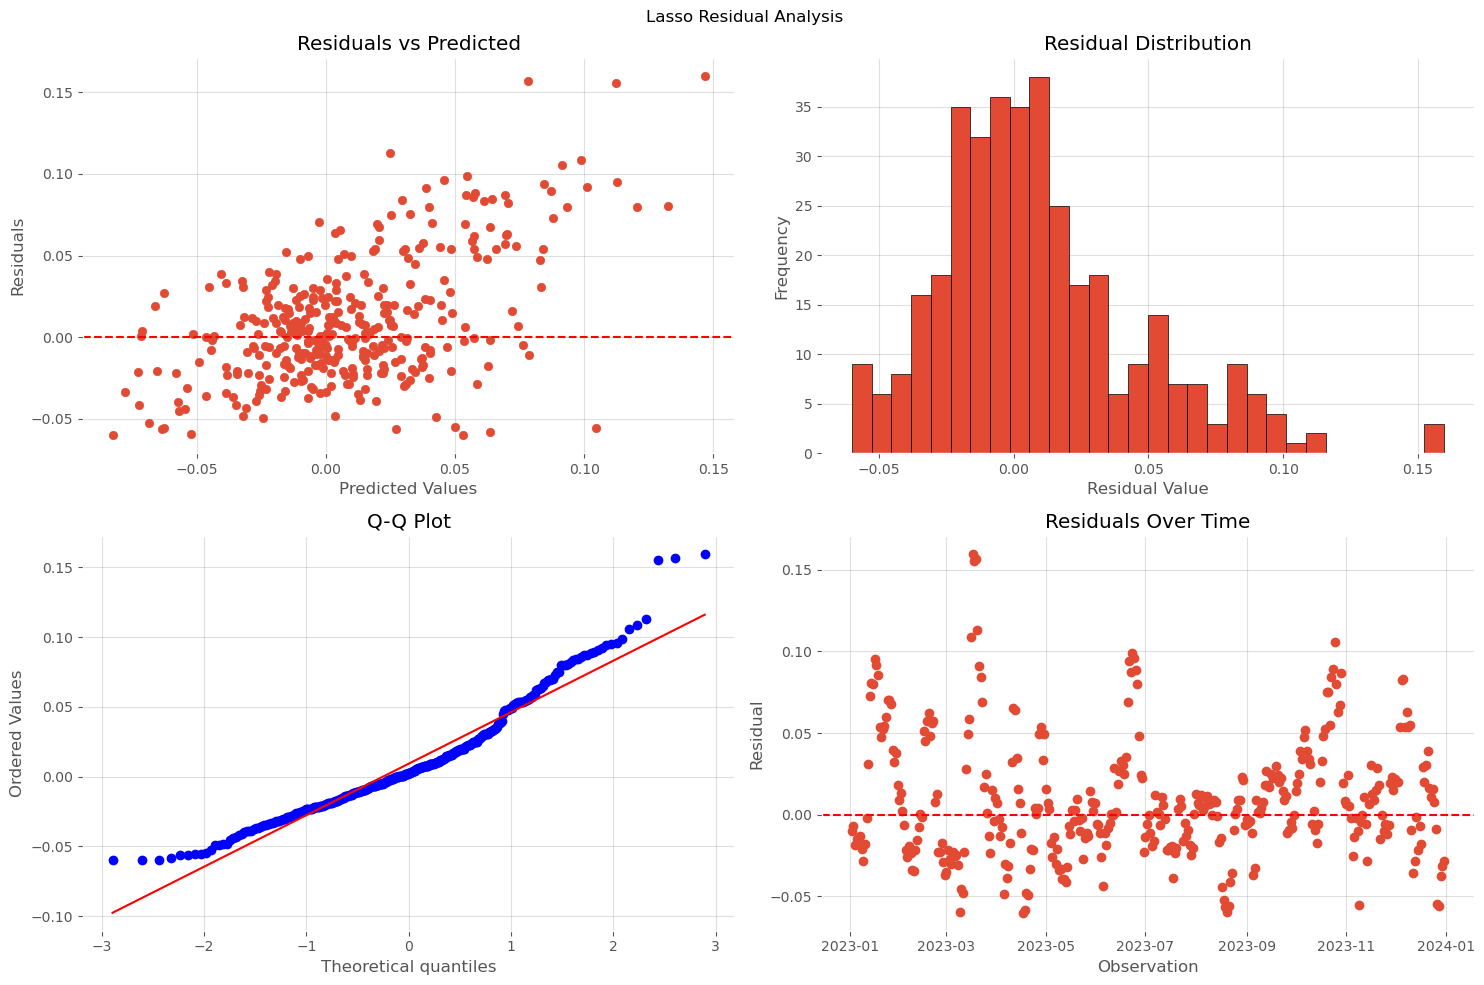


Residual Statistics:
Mean: 0.0093
Std Dev: 0.0377
Skewness: 0.9706
Kurtosis: 1.3004
Jarque-Bera p-value: 0.0000

Model Performance Summary:

OLS:
R2: 0.6696
RMSE: 0.0379
MAE: 0.0284
CV_Score: 0.6272

Ridge:
R2: 0.6658
RMSE: 0.0381
MAE: 0.0285
CV_Score: 0.6289

Lasso:
R2: 0.6535
RMSE: 0.0388
MAE: 0.0282
CV_Score: 0.6523

Detailed OLS Summary:
                            OLS Regression Results                            
Dep. Variable:             BTC_Return   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     454.4
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:12:30   Log-Likelihood:                 2124.9
No. Observations:                1454   AIC:                            -4234.
Df Residuals:                    1446   BIC:                            -4192.
Df Model:              

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from scipy import stats

def analyze_features(data, target_col='BTC_Return'):
    """Analyze feature correlations and distributions"""
    # Correlation analysis
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Feature distributions
    data.hist(figsize=(15, 10))
    plt.tight_layout()
    plt.show()
    
    return data.corr()[target_col].sort_values(ascending=False)

def prepare_data(data, train_size=0.8, target_col='BTC_Return'):
    """Prepare data with proper train-test split and preprocessing"""
    # Create copy to avoid modifications to original data
    ols_data = data.copy()
    ols_data = ols_data.reindex(columns=['SP500', 'NASDAQ', "USD_Index", "Gold", 'BTC_users', 'BTC_tx_count', 'ETH_Return',
        'BTC_Return'])
    
    # Split features and target
    X = ols_data.drop(target_col, axis=1)
    y = ols_data[target_col]
    
    # Time series split
    split_index = int(len(ols_data) * train_size)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    return X_train, X_test, y_train, y_test

def preprocess_features(X_train, X_test):
    """Preprocess features with variance threshold and scaling"""
    # Remove zero-variance features
    var_threshold = VarianceThreshold(threshold=0)
    X_train_var = var_threshold.fit_transform(X_train)
    X_test_var = var_threshold.transform(X_test)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_var)
    X_test_scaled = scaler.transform(X_test_var)
    
    # Get feature names after variance threshold
    features_kept = X_train.columns[var_threshold.get_support()].tolist()
    
    return X_train_scaled, X_test_scaled, features_kept

def optimize_components(X_train_scaled, threshold=0.95):
    """Determine optimal number of components using PCA"""
    pca = PCA()
    pca.fit(X_train_scaled)
    
    # Plot explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(explained_variance) + 1), explained_variance)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    
    plt.tight_layout()
    plt.show()
    
    optimal_components = np.argmax(cumulative_variance >= threshold) + 1
    return optimal_components

def plot_feature_importance(model, features_kept, model_name):
    """Plot feature importance for a given model"""
    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
        if len(importance.shape) > 1:  # If coefficients are 2D array
            importance = importance[0]
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        return
    
    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': features_kept,
        'Importance': importance
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'{model_name} Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

def analyze_residuals(y_test, y_pred, model_name):
    """Analyze and plot residuals"""
    residuals = y_test - y_pred
    
    # Create subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Residual scatter plot
    axes[0, 0].scatter(y_pred, residuals)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Predicted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Predicted')
    
    # Residual histogram
    axes[0, 1].hist(residuals, bins=30, edgecolor='black')
    axes[0, 1].set_xlabel('Residual Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Residual Distribution')
    
    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')
    
    # Residual time series
    axes[1, 1].plot(residuals, marker='o', linestyle='none')
    axes[1, 1].axhline(y=0, color='r', linestyle='--')
    axes[1, 1].set_xlabel('Observation')
    axes[1, 1].set_ylabel('Residual')
    axes[1, 1].set_title('Residuals Over Time')
    
    plt.suptitle(f'{model_name} Residual Analysis')
    plt.tight_layout()
    plt.show()
    
    # Calculate residual statistics
    residual_stats = {
        'Mean': np.mean(residuals),
        'Std Dev': np.std(residuals),
        'Skewness': stats.skew(residuals),
        'Kurtosis': stats.kurtosis(residuals),
        'Jarque-Bera p-value': stats.jarque_bera(residuals)[1]
    }
    
    return residual_stats

def train_evaluate_models(X_train, X_test, y_train, y_test, features_kept):
    """Train and evaluate multiple regression models with feature importance analysis"""
    # Initialize models
    models = {
        'OLS': LinearRegression(),
        'Ridge': RidgeCV(alphas=np.logspace(-6, 6, 13)),
        'Lasso': LassoCV(random_state=42)
    }
    
    results = {}
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        results[name] = {
            'R2': r2_score(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred)
        }
        
        # Time series cross-validation
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores = cross_val_score(model, X_train, y_train, cv=tscv)
        results[name]['CV_Score'] = cv_scores.mean()
        
        # Plot feature importance
        print(f"\nFeature Importance for {name}:")
        feature_importance = plot_feature_importance(model, features_kept, name)
        if feature_importance is not None:
            print(feature_importance)
        
        # Analyze residuals
        print(f"\nResidual Analysis for {name}:")
        residual_stats = analyze_residuals(y_test, y_pred, name)
        print("\nResidual Statistics:")
        for stat_name, value in residual_stats.items():
            print(f"{stat_name}: {value:.4f}")
        
    return results

# Main execution
def main(data):
    # Analyze features
    correlation_analysis = analyze_features(data)
    print("\nFeature Correlations with BTC Return:")
    print(correlation_analysis)
    
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data(data)
    
    # Preprocess features
    X_train_scaled, X_test_scaled, features_kept = preprocess_features(X_train, X_test)
    
    # Optimize components
    optimal_components = optimize_components(X_train_scaled)
    print(f"\nOptimal number of components: {optimal_components}")
    
    # Train and evaluate models
    results = train_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test, features_kept)
    
    # Print results
    print("\nModel Performance Summary:")
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
            
    # Detailed statsmodels summary for OLS
    X_train_const = sm.add_constant(X_train_scaled)
    model_sm = sm.OLS(y_train, X_train_const).fit()
    print("\nDetailed OLS Summary:")
    print(model_sm.summary())

# Example usage:
main(data)  # Uncomment and run with your data